<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37500 - Fixed Income Derivatives</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework #4- SABR, Volatility Modeling, and Risk Management </center></h2>

<center>Due: Wednesday, Mar 4 at 6PM</center>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

# Homework 4

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

***

In [151]:
import numpy as np
import pandas as pd
import datetime
import warnings
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert(0, '../cmds')
from my_cmds import *

In [152]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm
import math
import datetime
import matplotlib.pyplot as plt
import holidays
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.offsets import Day, BDay
from datetime import date

import numpy.polynomial.polynomial as poly


# TREASURY CMDS FUNCS:
def semi_bootstrap(params,maturity, n_compound):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities, n_compound=n_compound)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate


def bday(date):
    """
    Check if a given date is a business day in the US.

    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is a business day, False otherwise.
    """
    us_bus = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    return bool(len(pd.bdate_range(date, date, freq=us_bus)))

def prev_bday(date, force_prev=False):
    """
    Returns the previous business day given a date.

    Parameters:
    date (str or datetime.datetime): The input date in the format 'YYYY-MM-DD' or as a datetime object.
    force_prev (bool, optional): If True, forces the function to return the previous business day even if the input date is already a business day. Defaults to False.

    Returns:
    str or datetime.datetime: The previous business day as a string in the format 'YYYY-MM-DD' if the input date is a string, or as a datetime object if the input date is a datetime object.
    """
    if isinstance(date, str):
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
        date2str = True
    else:
        date2str = False
        
    if force_prev:
        date += -datetime.timedelta(days=1)
    while not bday(date):
        date += -datetime.timedelta(days=1)
    
    if date2str:
        date = date.strftime('%Y-%m-%d')
        
    return date

def get_coupon_dates(quote_date, maturity_date):
    """
    Returns a list of coupon dates between the quote date and maturity date.

    Parameters:
    quote_date (str or datetime.datetime): The quote date in the format 'YYYY-MM-DD' or as a datetime object.
    maturity_date (str or datetime.datetime): The maturity date in the format 'YYYY-MM-DD' or as a datetime object.

    Returns:
    list: A list of coupon dates between the quote date and maturity date.
    """
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date - quote_date).days / 180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out



def make_figure_number_issues_paying(CFmatrix):
    """
    Creates a figure showing the number of treasury issues with coupon or principal payment over time.

    Parameters:
    CFmatrix (numpy.ndarray): The cash flow matrix representing the treasury issues.

    Returns:
    None
    """
    mask_issues_paying = (CFmatrix!=0).sum()

    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(mask_issues_paying,marker='*',linestyle='None')

    #set ticks every quarter
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(2,5,8,11)))
    ax.xaxis.set_major_locator(mdates.YearLocator(month=2))

    #format ticks
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=60, horizontalalignment='right')

    ax.margins(x=0)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    plt.ylabel('number of treasury issues with coupon or principal payment')
    plt.title('Number of Treasuries Paying')

    plt.show()



def filter_treasuries(data, t_date=None, filter_maturity=None, filter_maturity_min=None, drop_duplicate_maturities=False, filter_tips=True, filter_yld=True):
    """
    Filter treasury data based on specified criteria.

    Parameters:
    - data: DataFrame, the treasury data to be filtered.
    - t_date: datetime, the date to filter the data on. If None, the latest date in the data will be used.
    - filter_maturity: int, the maximum maturity in years to filter the data on. Default is None.
    - filter_maturity_min: int, the minimum maturity in years to filter the data on. Default is None.
    - drop_duplicate_maturities: bool, whether to drop duplicate maturities. Default is False.
    - filter_tips: bool, whether to filter out TIPS (Treasury Inflation-Protected Securities). Default is True.
    - filter_yld: bool, whether to filter out securities with zero yield. Default is True.

    Returns:
    - outdata: DataFrame, the filtered treasury data.
    """
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT'] == t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365 * filter_maturity + 1, 'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365 * filter_maturity_min - 1, 'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['ITYPE'].isin([11, 12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['TDYLD'] > 0]
        
    return outdata



def calc_cashflows(quote_data, filter_maturity_dates=False):
    """
    Calculate cashflows based on quote data.

    Args:
        quote_data (pd.DataFrame): DataFrame containing quote data.
        filter_maturity_dates (bool, optional): Flag to filter cashflows based on maturity dates. 
            Defaults to False.

    Returns:
        pd.DataFrame: DataFrame containing calculated cashflows.
    """
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100

    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF


def check_dates(df):
    t_check = df['CALDT'].values[0]
    if df['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
    return t_current

def data_summary(rdata, t_current):
    '''
    Performs calculations of process treasury quotes if filepath is different.
    Make sure ['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT'] are in the rdata
    
    '''
    res = rdata[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']].copy()
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    res.columns = ['issue date','maturity date','coupon rate','yld', 'duration','outstanding']
    res['yld'] *= 365
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    res['duration'] /= 365
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    res['outstanding'] *= 1e6
    res['maturity interval'] = get_maturity_delta(res['maturity date'], t_current)
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    res['price'] = (rdata['TDBID'] + rdata['TDASK'])/2 + rdata['TDACCINT']
    res['bid-ask'] = rdata['TDASK'] - rdata['TDBID']
    res['next cashflow'] = (calc_cashflows(rdata)!=0).idxmax(1)
    return res

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    """
    Filter treasury cashflows based on specified criteria.

    Parameters:
    CF (DataFrame): The cashflow data.
    filter_maturity_dates (bool): Flag indicating whether to filter by maturity dates. Default is False.
    filter_benchmark_dates (bool): Flag indicating whether to filter by benchmark dates. Default is False.
    filter_CF_strict (bool): Flag indicating whether to filter cashflows strictly. Default is True.

    Returns:
    DataFrame: The filtered cashflow data.
    """
    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered



def get_maturity_delta(t_maturity, t_current):
    """
    Calculates the maturity delta in years between the given maturity date and the current date.

    Parameters:
    t_maturity (datetime): The maturity date.
    t_current (datetime): The current date.

    Returns:
    float: The maturity delta in years.
    """
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta



def discount_to_intrate(discount, maturity, n_compound=None):
    """
    Calculates the interest rate given the discount factor and maturity.

    Parameters:
    discount (float): The discount factor.
    maturity (float): The time to maturity in years.
    n_compound (int, optional): The number of times interest is compounded per year. 
                                If not provided, interest is continuously compounded.

    Returns:
    float: The interest rate.

    """
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate




def intrate_to_discount(intrate, maturity, n_compound=None):
    """
    Calculates the discount factor given an interest rate and maturity.

    Parameters:
    intrate (float): The interest rate.
    maturity (float): The time to maturity in years.
    n_compound (int, optional): The number of times interest is compounded per year. 
                                If not provided, the discount factor is calculated using continuous compounding.

    Returns:
    float: The discount factor.
    """
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount



def compound_rate(intrate, compound_input, compound_output):
    """
    Calculates the compound rate based on the given interest rate and compounding periods.

    Parameters:
    intrate (float): The interest rate.
    compound_input (float): The number of compounding periods for the input rate.
    compound_output (float): The number of compounding periods for the output rate.

    Returns:
    float: The compound rate.

    """
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate







def bootstrap(params, maturity):
    """
    Calculates the interpolated interest rate for a given maturity using the bootstrap method.

    Parameters:
    params (tuple): A tuple containing the estimated maturities and betas.
    maturity (float): The maturity for which the interest rate needs to be calculated.

    Returns:
    float: The interpolated interest rate for the given maturity.
    """
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate



def nelson_siegel(params, maturity):
    """
    Calculates the Nelson-Siegel interest rate based on the given parameters and maturity.

    Parameters:
    params (list): A list of parameters [a, b, c, d] used in the Nelson-Siegel formula.
    maturity (float): The time to maturity in years.

    Returns:
    float: The calculated Nelson-Siegel interest rate.
    """
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate





def nelson_siegel_extended(params, maturity):
    """
    Calculates the Nelson-Siegel Extended rate for a given set of parameters and maturity.

    Parameters:
    params (list): A list of parameters [param1, param2, param3, param4, param5, param6].
    maturity (float): The time to maturity in years.

    Returns:
    rate (float): The calculated Nelson-Siegel Extended rate.
    """
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate




def estimate_curve_ols(CF, prices, interpolate=False):
    """
    Estimates the curve using ordinary least squares (OLS) regression.

    Parameters:
        CF (pd.DataFrame or pd.Series): Cash flows.
        prices (pd.DataFrame or pd.Series or np.ndarray): Prices.
        interpolate (bool, optional): Whether to interpolate the curve. Defaults to False.

    Returns:
        np.ndarray: Estimated curve discounts.
    """

    if isinstance(prices, pd.DataFrame) or isinstance(prices, pd.Series):
        prices = prices[CF.index].values

    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())

        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)

    else:
        discounts = mod.coef_

    return discounts




def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    """
    Calculates the price of a fixed income security using a rate model.

    Parameters:
    params (list): List of parameters for the rate model.
    CF (numpy.ndarray): Cash flow of the fixed income security.
    t_current (float): Current time.
    fun_model (function): Function that models the interest rate.
    convert_to_discount (bool, optional): Flag to convert interest rates to discount factors. Defaults to True.
    price_coupons (bool, optional): Flag to include coupon payments in the price calculation. Defaults to False.

    Returns:
    numpy.ndarray: Price of the fixed income security.
    """

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price




def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    """
    Calculates the pricing errors between the observed prices and the modeled prices.

    Parameters:
    params (list): List of parameters for the rate model.
    CF (list): List of cash flows.
    t_current (float): Current time.
    fun_model (function): Function representing the rate model.
    observed_prices (array-like): Array-like object containing the observed prices.

    Returns:
    float: The sum of squared pricing errors.
    """
    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)

    if isinstance(observed_prices, pd.DataFrame) or isinstance(observed_prices, pd.Series):
        observed_prices = observed_prices.values

    error = sum((observed_prices - price_modeled) ** 2)

    return error


def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    """
    Estimates the rate curve parameters based on the given model.

    Parameters:
        model (str): The model used for estimation. Possible values are 'bootstrap', 'nelson_siegel', and 'nelson_siegel_extended'.
        CF (DataFrame): Cash flow matrix.
        t_current (float): Current time.
        prices (Series): Bond prices.
        x0 (array-like, optional): Initial guess for the optimization algorithm. Default is None.

    Returns:
        array-like: Optimized rate curve parameters.
    """
    if model is bootstrap:
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
    
        params_optimized = [CF_intervals, params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized



def extract_spot_curves(quote_date, filepath=None, model=nelson_siegel, delta_maturity = .25, T=30,calc_forward=False, delta_forward_multiple = 1, filter_maturity_dates=False, filter_tips=True):
    """
    Extracts spot curves from treasury quotes data.

    Parameters:
    - quote_date (str): The date of the treasury quotes.
    - filepath (str, optional): The file path of the treasury quotes data. If not provided, a default path will be used.
    - model (function, optional): The model used to estimate the rate curve. Default is nelson_siegel.
    - delta_maturity (float, optional): The increment between maturities in the maturity grid. Default is 0.25.
    - T (int, optional): The maximum maturity in the maturity grid. Default is 30.
    - calc_forward (bool, optional): Whether to calculate forward rates. Default is False.
    - delta_forward_multiple (int, optional): The multiple of delta_maturity used to calculate the delta forward. Default is 1.
    - filter_maturity_dates (bool, optional): Whether to filter maturity dates. Default is False.
    - filter_tips (bool, optional): Whether to filter TIPS (Treasury Inflation-Protected Securities). Default is True.

    Returns:
    - curves (DataFrame): DataFrame containing spot rates, spot discounts, and optionally forward rates and forward discounts.
    """
    if filepath is None:
        filepath = f'../data/treasury_quotes_{quote_date}.xlsx'
        
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    ###
    data = filter_treasuries(rawdata, t_date=t_current, filter_tips=filter_tips)

    CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=filter_maturity_dates)
    prices = rawprices[CF.index]

    ###
    params = estimate_rate_curve(model,CF,t_current,prices)
    
    if model == nelson_siegel_extended:
        params0 = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
        x0 = np.concatenate((params0,(1,1)))
        params = estimate_rate_curve(model,CF,t_current,prices,x0=x0)
        
    else:
        params = estimate_rate_curve(model,CF,t_current,prices)

    ###
    maturity_grid = np.arange(0,T+delta_maturity,delta_maturity)
    maturity_grid[0] = .01
    
    curves = pd.DataFrame(index = pd.Index(maturity_grid,name='maturity'))
    # adjust earliest maturity from 0 to epsion
    curves.columns.name = quote_date
    
    curves['spot rate']= model(params,maturity_grid)

    curves['spot discount'] = intrate_to_discount(curves['spot rate'].values,curves.index.values)
    
    
    
    if calc_forward:
        delta_forward = delta_forward_multiple * delta_maturity
        
        curves['forward discount'] = curves['spot discount'] / curves['spot discount'].shift(delta_forward_multiple)

        # first value of forward is spot rate
        maturity_init = curves.index[0:delta_forward_multiple]
        curves.loc[maturity_init,'forward discount'] = curves.loc[maturity_init,'spot discount']
        
        curves.insert(2,'forward rate', -np.log(curves['forward discount'])/delta_forward)
        
    return curves



def process_treasury_quotes(filepath):
    """
    Processes treasury quotes data and returns relevant metrics.

    Parameters:
    - quote_date (str): The date of the treasury quotes.

    Returns:
    - rawdata (DataFrame): DataFrame containing raw treasury quotes data.
    - metrics (DataFrame): DataFrame containing metrics such as issue date, maturity date, outstanding, coupon rate, yield, duration, maturity interval, and price.
    """
    
    # filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
    maturity_delta.name = 'maturity delta'

    metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
    metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
    metrics['yld'] *= 365
    metrics['duration'] /= 365
    metrics['outstanding'] *= 1e6
    metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
    metrics['price'] = rawprices
    metrics['bid-ask'] = rawdata['TDASK'] - rawdata['TDBID']
    metrics['next cashflow'] = (calc_cashflows(rawdata)!=0).idxmax(1)
    return rawdata, metrics


def get_bond(quote_date, maturity=None, coupon=None, selection='nearest'):
    """
    Retrieves bond metrics based on the specified criteria.

    Parameters:
    - quote_date (str): The date of the bond quote.
    - maturity (float or list): The maturity interval(s) of the bond(s) to retrieve. If a float is provided, it will be converted to a list.
    - coupon (float): The coupon rate of the bond(s) to retrieve.
    - selection (str): The method used to select bonds when multiple maturities are provided. Options are 'nearest', 'ceil', and 'floor'.

    Returns:
    - metrics (DataFrame): The bond metrics that match the specified criteria.
    """
    
    rawdata, metrics = process_treasury_quotes(f'../data/treasury_quotes_{quote_date}.xlsx')

    if coupon is not None:
        metrics = metrics[metrics['coupon rate'] == coupon]
    
    if maturity is not None:
        mats = metrics['maturity interval']

        if type(maturity) is float:
            maturity = [maturity]

        idx = list()

        for m in maturity:
            if selection == 'nearest':
                idx.append(mats.sub(m).abs().idxmin())
            elif selection == 'ceil':
                idx.append(mats.sub(m).where(mats > 0, np.inf).argmin())
            elif selection == 'floor':
                idx.append(mats.sub(m).where(mats < 0, -np.inf).argmax())

        metrics = metrics.loc[idx, :]

    return metrics


def get_bond_raw(quote_date):
    """
    Retrieves raw bond data from an Excel file for a given quote date.

    Parameters:
    quote_date (str): The date of the bond quotes in the format 'YYYY-MM-DD'.

    Returns:
    rawdata (pd.DataFrame): The raw bond data as a pandas DataFrame.
    t_current (str or None): The date of the bond quotes if they are all from the same date, otherwise None.
    """
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
        
    return rawdata, t_current


def forward_discount(spot_discount, T1, T2):
    """
    Calculates the forward discount factor between two time periods.

    Parameters:
    spot_discount (pandas.Series): A pandas Series containing spot discount factors for different time periods.
    T1 (int): The starting time period.
    T2 (int): The ending time period.

    Returns:
    float: The forward discount factor between T1 and T2.
    """
    return spot_discount.loc[T2] / spot_discount.loc[T1]


def calc_npv(rate=0, cashflows=0, maturities=0, price=0):
    """
    Calculates the Net Present Value (NPV) of a series of cashflows.

    Parameters:
    rate (float): The discount rate used to calculate the NPV.
    cashflows (list): List of cashflows.
    maturities (list): List of maturities corresponding to each cashflow.
    price (float): The price of the investment.

    Returns:
    float: The calculated NPV.
    """
        
    temp = cashflows.copy()
    val = sum([cfi/(1+rate)**(maturities[i]) for i, cfi in enumerate(temp)])
    val += - price

    return val


def pv(rate, cashflows, maturities, freq=1):
    """
    Calculates the present value of a series of cashflows.

    Parameters:
    rate (float): The discount rate.
    cashflows (list): List of cashflows.
    maturities (list): List of maturities corresponding to each cashflow.
    freq (int, optional): Number of compounding periods per year. Default is 1.

    Returns:
    float: The present value of the cashflows.
    """
    price = sum([cfi / (1 + rate / freq) ** (maturities[i] * freq) for i, cfi in enumerate(cashflows)])
    return price


def next_business_day(DATE):
    """
    Calculates the next business day given a date.

    Args:
        DATE (datetime.date): The input date.

    Returns:
        datetime.date: The next business day.
    """
    ONE_DAY = datetime.timedelta(days=1)
    HOLIDAYS_US = holidays.US()

    next_day = DATE
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day


def price_treasury_ytm(time_to_maturity, ytm, cpn_rate, freq=2, face=100):
    """
    Calculates the price of a treasury bond given the time to maturity, yield to maturity, coupon rate, frequency, and face value.

    Parameters:
    time_to_maturity (float): Time to maturity in years.
    ytm (float): Yield to maturity as a decimal.
    cpn_rate (float): Coupon rate as a decimal.
    freq (int, optional): Coupon payment frequency per year. Defaults to 2.
    face (int, optional): Face value of the bond. Defaults to 100.

    Returns:
    float: The price of the treasury bond.
    """
    c = cpn_rate/freq
    y = ytm/freq
    
    tau = round(time_to_maturity * freq)
    
    pv = 0
    for i in range(1,tau):
        pv += 1 / (1+y)**i
    
    pv = c*pv + (1+c)/(1+y)**tau
    pv *= face
    
    return pv



def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):
    """
    Calculates the duration of a fixed-income security using the closed-formula method.

    Parameters:
    - tau (float): Time to maturity in years.
    - ytm (float): Yield to maturity as a decimal.
    - cpnrate (float, optional): Coupon rate as a decimal. If not provided, it is assumed to be equal to the yield to maturity.
    - freq (int, optional): Number of coupon payments per year. Default is 2.

    Returns:
    - duration (float): Duration of the fixed-income security.
    """
    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration


def get_spread_bps(database):
    """
    Calculate the spread in basis points (bps) for each treasury bond in the database.

    Parameters:
    - database: pandas DataFrame containing the treasury bond data

    Returns:
    - spread: pandas DataFrame containing the spread in bps for each treasury bond
    """
    ylds = database.pivot_table(index='CALDT',columns='KYTREASNO',values='TDYLD')
    ylds *= 365 * 100 * 100
    
    spread = -ylds.sub(ylds.iloc[:,0],axis=0)
    
    return spread



def get_key_info(info):
    """
    Retrieves key information from the given DataFrame.

    Parameters:
    info (DataFrame): The DataFrame containing the information.

    Returns:
    DataFrame: The key information with updated column names and type labels.
    """
    keys = ['kytreasno','tdatdt','tmatdt','tcouprt','itype']
    key_info = info.loc[keys]
    key_info.index = ['kytreasno','issue date','maturity date','coupon rate','type']
    key_info.loc['type',key_info.loc['type']==1] = 'bond'
    key_info.loc['type',key_info.loc['type']==2] = 'note'
    key_info.loc['type',key_info.loc['type']==3] = 'bill'
    key_info.loc['type',key_info.loc['type']==11] = 'TIPS bond'
    key_info.loc['type',key_info.loc['type']==12] = 'TIPS note'
    key_info.columns = key_info.loc['issue date']
    return key_info



def get_snapshot(database, date):
    """
    Retrieves a snapshot of treasury metrics for a given date from a database.

    Parameters:
    - database (DataFrame): The database containing treasury data.
    - date (str): The date for which the snapshot is requested.

    Returns:
    - metrics (DataFrame): A DataFrame containing various treasury metrics for the specified date.
    """

    datasnap = database[database['CALDT'] == date].T

    metrics = datasnap.loc[['KYTREASNO', 'CALDT', 'TDBID', 'TDASK', 'TDACCINT']]
    metrics.loc['clean price'] = (metrics.loc['TDBID'] + metrics.loc['TDASK']) / 2
    metrics.loc['dirty price'] = metrics.loc['clean price'] + metrics.loc['TDACCINT']
    metrics.loc['duration'] = datasnap.loc['TDDURATN'] / 365.25
    ytm = (datasnap.loc['TDYLD'] * 365.25)
    metrics.loc['modified duration'] = metrics.loc['duration'] / (1 + ytm / 2)
    metrics.loc['ytm'] = ytm
    metrics.columns = metrics.loc['CALDT']
    metrics.drop('CALDT', inplace=True)
    metrics.index = metrics.index.str.lower()
    metrics.rename({'tdbid': 'bid', 'tdask': 'ask', 'tdaccint': 'accrued interest'}, inplace=True)

    return metrics



def get_table(info, database, date):
    """
    Retrieves a table by merging key information and metrics based on the given parameters.

    Parameters:
        info (str): The key information.
        database (str): The database to retrieve metrics from.
        date (str): The date of the snapshot.

    Returns:
        pandas.DataFrame: The merged table.
    """

    keyinfo = get_key_info(info)
    metrics = get_snapshot(database, date)

    table = pd.merge(keyinfo.T, metrics.T, on='kytreasno', how='inner').T
    table.columns = table.loc['kytreasno']
    table.drop('kytreasno', inplace=True)

    return table


def pnl_spread_trade(spread_convergence, modified_duration, price, contracts):    
    """
    Calculate the profit and loss (pnl) of a spread trade based on spread convergence, modified duration, price, and contracts.

    Parameters:
    spread_convergence (float): The spread convergence value.
    modified_duration (pd.Series): A pandas Series containing modified duration values.
    price (pd.Series): A pandas Series containing price values.
    contracts (pd.Series): A pandas Series containing contract values.

    Returns:
    tuple: A tuple containing the pnl table and a dictionary of formatting options.
    """
    table = pd.DataFrame(dtype='float64',index=modified_duration.index)
    table['ytm change'] = spread_convergence/2 * np.array([-1,1])
    table['modified duration'] = modified_duration    
    table['price'] = price
    table['contracts'] = contracts
    table['pnl'] = - table['modified duration'] * table['price'] * table['ytm change'] * table['contracts']
    table.loc['total','pnl'] = table['pnl'].sum()
        
    fmt_dict = {'ytm change':'{:.4%}','modified duration':'{:,.2f}','dollar modified duration':'{:,.2f}','contracts':'{:,.2f}','price':'${:,.2f}','pnl':'${:,.2f}'}
    
    return table, fmt_dict

def trade_balance_sheet(prices, durations, haircuts, key_long, key_short, long_equity=None, long_assets=None):
    """
    Calculate the balance sheet for a trade based on prices, durations, haircuts, and positions.

    Parameters:
    prices (pd.Series): Series of prices for the assets.
    durations (pd.Series): Series of durations for the assets.
    haircuts (pd.Series): Series of haircuts for the assets.
    key_long (str): Key for the long position.
    key_short (str): Key for the short position.
    long_equity (float, optional): Long equity position. Defaults to None.
    long_assets (float, optional): Long assets position. Defaults to None.

    Returns:
    tuple: A tuple containing the balance sheet dataframe and the format dictionary.
    """
    hedge_ratio = -durations[key_long]/durations[key_short]

    balsheet = pd.DataFrame(dtype='float64',index=[key_long,key_short],columns=['equity','assets'])

    if long_equity is not None:
        balsheet['assets'] = long_equity / haircuts.values
    elif long_assets is not None:
        balsheet.loc[key_long,'assets'] = long_assets
    else:
        error('Must input long equity or long assets.')
        
    balsheet.loc[key_short,'assets'] = balsheet.loc[key_long,'assets'] * hedge_ratio
    balsheet['equity'] = balsheet['assets'] * haircuts.values

    balsheet['contracts'] = balsheet['assets'] / prices
    fmt = {'equity':'${:,.2f}','assets':'${:,.2f}','contracts':'{:,.2f}'}
    
    return balsheet, fmt

def trade_evolution(date0, date_maturity, n_weeks, balsheet, price_ts, duration_ts, financing, cpn_rates, key_long, key_short):
    """
    Calculates the trade evolution over a specified number of weeks.

    Parameters:
    date0 (str): The starting date in the format 'YYYY-MM-DD'.
    date_maturity (str): The maturity date in the format 'YYYY-MM-DD'.
    n_weeks (int): The number of weeks to calculate the trade evolution.
    balsheet (pd.DataFrame): The balance sheet data.
    price_ts (pd.DataFrame): The price time series data.
    duration_ts (pd.DataFrame): The duration time series data.
    financing (dict): The financing data.
    cpn_rates (float): The coupon rates.
    key_long (str): The key for long assets.
    key_short (str): The key for short assets.

    Returns:
    pnl (pd.DataFrame): The profit and loss data.
    fmt_dict (dict): The formatting dictionary for display.
    """
    dt0 = datetime.datetime.strptime(date0,'%Y-%m-%d') 
    
    cpn_dates = get_coupon_dates(date0,date_maturity)
    
    pnl = pd.DataFrame(dtype='float64',index=[dt0],columns=['price change', 'coupons', 'total pnl', 'equity'])
    pnl.loc[dt0] = [0, 0, 0, balsheet['equity'].abs().sum()]

    for i in range(1,n_weeks):
        dt = dt0 + datetime.timedelta(weeks=i)
        dt = prev_bday(dt)

        cpn_payments = (dt > cpn_dates).sum()
        pnl.loc[dt,'price change'] = (price_ts.loc[[dt0,dt]] * balsheet['contracts']).diff().sum(axis=1).loc[dt]
        pnl.loc[dt,'coupons'] = (cpn_rates * balsheet['contracts'] * cpn_payments / 2).sum()
        pnl.loc[dt,'total pnl'] = pnl.loc[dt,['price change','coupons']].sum()

        temp, _ = trade_balance_sheet(price_ts.loc[dt], duration_ts.loc[dt], financing['haircut'], key_long, key_short, long_assets=balsheet.loc[key_long,'contracts']*price_ts.loc[dt,key_long])
        pnl.loc[dt,'equity'] = temp['equity'].abs().sum()

    pnl['margin call'] = pnl['equity'].diff() - pnl['total pnl'].diff()
    pnl.loc[dt0,'margin call'] = 0
    pnl['capital paid in'] = pnl['equity'] + pnl['margin call'].cumsum()

    pnl['return (init equity)'] = pnl['total pnl'] / pnl.loc[dt0,'capital paid in']
    pnl['return (avg equity)'] = pnl['total pnl'] / pnl['capital paid in'].expanding().mean()

    fmt_dict = {'price change':'${:,.2f}','coupons':'${:,.2f}','total pnl':'${:,.2f}','equity':'${:,.2f}','margin call':'${:,.2f}','capital paid in':'${:,.2f}', 'return (init equity)':'{:.2%}', 'return (avg equity)':'{:.2%}'}

    return pnl, fmt_dict


def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)



# BINOMIAL FUNCS:

def format_bintree(df, style='{:.2f}'):
    """
    Formats a binary tree represented as a DataFrame.

    Args:
        df (pandas.DataFrame): The binary tree represented as a DataFrame.
        style (str, optional): The formatting style to apply. Defaults to '{:.2f}'.

    Returns:
        pandas.io.formats.style.Styler: The formatted binary tree.
    """
    return df.style.format(style, na_rep='').format_index('{:.2f}', axis=1)

def construct_rate_tree(dt,T):
    """
    Constructs a rate tree based on the given time step and time horizon.

    Parameters:
    dt (float): The time step.
    T (float): The time horizon.

    Returns:
    pd.DataFrame: The rate tree.
    """
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree



def construct_quotes(maturities, prices):
    """
    Constructs a DataFrame of quotes with maturities, prices, and continuous yield to maturity (YTM).

    Parameters:
    maturities (list): List of maturities for each quote.
    prices (list): List of prices for each quote.

    Returns:
    quotes (DataFrame): DataFrame containing maturities, prices, and continuous YTM.
    """
    quotes = pd.DataFrame({'maturity': maturities, 'price': prices})    
    quotes['continuous ytm'] = -np.log(quotes['price']/100) / quotes['maturity']
    quotes.set_index('maturity', inplace=True)
    
    return quotes

def payoff_bond(r, dt, facevalue=100):
    """
    Calculates the payoff of a bond.

    Parameters:
    - r (float): The interest rate.
    - dt (float): The time period.
    - facevalue (float, optional): The face value of the bond. Default is 100.

    Returns:
    - price (float): The calculated bond price.
    """
    price = np.exp(-r * dt) * facevalue
    return price

def payoff_swap(r, swaprate, freqswap, ispayer=True, N=100):
    """
    Calculates the payoff of a swap contract.

    Parameters:
    - r (float): The interest rate.
    - swaprate (float): The fixed rate of the swap.
    - freqswap (float): The frequency of the swap payments.
    - ispayer (bool, optional): Specifies whether the party is the payer or receiver of the swap. Default is True.
    - N (int, optional): The notional amount of the swap. Default is 100.

    Returns:
    - payoff (float): The payoff of the swap contract.
    """
    if ispayer:
        payoff = N * (r - swaprate) / freqswap
    else:
        payoff = N * (swaprate - r) / freqswap

    return payoff


def replicating_port(quotes, undertree, derivtree, dt=None, Ncash=100):
    """
    Calculates the replicating portfolio for a derivative given the quotes, undertree, and derivtree.

    Parameters:
    quotes (array-like): The quotes for the derivative.
    undertree (DataFrame): The underlying asset price tree.
    derivtree (DataFrame): The derivative price tree.
    dt (float, optional): The time step size. If not provided, it is calculated from the undertree.
    Ncash (float, optional): The amount of cash to invest. Default is 100.

    Returns:
    DataFrame: The replicating portfolio positions and their values.
    """

    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]
    
    delta = (derivtree.loc[0, dt] - derivtree.loc[1, dt]) / (undertree.loc[0, dt] - undertree.loc[1, dt]) 
    cash = (derivtree.loc[0, dt] - delta * undertree.loc[0, dt]) / Ncash
    
    out = pd.DataFrame({'positions': [cash, delta], 'value': quotes}, index=['cash', 'under'])
    out.loc['derivative', 'value'] = out['positions'] @ out['value']
    return out


def bintree_pricing_old(payoff=None, ratetree=None, undertree=None, cftree=None, pstars=None, timing=None, style='european'):
    """
    Calculates the binomial tree pricing for a financial derivative.

    Parameters:
    - payoff (function): The payoff function for the derivative. Default is None.
    - ratetree (DataFrame): The interest rate tree. Default is None.
    - undertree (DataFrame): The underlying asset price tree. Default is None.
    - cftree (DataFrame): The cash flow tree. Default is None.
    - pstars (Series): The probability tree. Default is None.
    - timing (str): The timing of the derivative. Default is None.
    - style (str): The style of the derivative. Default is 'european'.

    Returns:
    - valuetree (DataFrame): The binomial tree with calculated values.
    """

    if payoff is None:
        payoff = lambda r: payoff_bond(r, dt)

    if undertree is None:
        undertree = ratetree

    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)

    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if undertree.columns.to_series().diff().std() > 1e-5:
        display('time grid is unevenly spaced')
    dt = undertree.columns[1] - undertree.columns[0]

    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back == 0:
            valuetree[t] = payoff(undertree[t])
            if timing == 'deferred':
                valuetree[t] *= np.exp(-ratetree[t] * dt)
        else:
            for state in valuetree[t].index[:-1]:
                valuetree.loc[state, t] = np.exp(-ratetree.loc[state, t] * dt) * (
                            pstars[t] * valuetree.iloc[state, -steps_back] + (1 - pstars[t]) *
                            valuetree.iloc[state + 1, -steps_back] + cftree.loc[state, t])

            if style == 'american':
                valuetree.loc[:, t] = np.maximum(valuetree.loc[:, t],
                                                 payoff(undertree.loc[:, t]) + np.exp(-ratetree.loc[:, t] * dt) *
                                                 cftree.loc[:, t])

    return valuetree



def bintree_pricing(payoff=None, ratetree=None, undertree=None, cftree=None, dt=None, pstars=None, timing=None, cfdelay=False, style='european', Tamerican=0):
    """
    Calculates the pricing of an option using a binomial tree model.

    Parameters:
    - payoff (function): The payoff function of the option. Default is None.
    - ratetree (DataFrame): The interest rate tree. Default is None.
    - undertree (DataFrame): The underlying asset price tree. Default is None.
    - cftree (DataFrame): The cash flow tree. Default is None.
    - dt (float): The time step size. Default is None.
    - pstars (Series): The probability of up movement in the binomial tree. Default is None.
    - timing (str): The timing of the cash flows. Default is None.
    - cfdelay (bool): Whether to delay the cash flows. Default is False.
    - style (str): The option style. Default is 'european'.
    - Tamerican (float): The time at which the option becomes American style. Default is 0.

    Returns:
    - valuetree (DataFrame): The tree of option values at each node.
    """
    
    if payoff is None:
        payoff = lambda r: 0
    
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]
    
    if timing == 'deferred':
        cfdelay = True
    
    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state,t]
                else:                    
                    cf = cftree.iloc[state,-steps_back]
                
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))
        
    return valuetree


def bond_price_error(quote, pstars, ratetree, style='european'):
    """
    Calculates the error between the model price and the given quote for a bond.

    Parameters:
    quote (float): The quoted price of the bond.
    pstars (list): List of probabilities for the binomial tree.
    ratetree (DataFrame): DataFrame representing the interest rate tree.
    style (str, optional): The style of the option. Defaults to 'european'.

    Returns:
    float: The error between the model price and the quote.
    """
    FACEVALUE = 100
    dt = ratetree.columns[1] - ratetree.columns[0]    
    payoff = lambda r: payoff_bond(r,dt)
    modelprice = bintree_pricing(payoff, ratetree, pstars=pstars, style=style).loc[0,0]
    error = modelprice - quote

    return error


def estimate_pstar(quotes,ratetree,style='european'):
    """
    Estimates the pstar values for each time step in the ratetree.

    Parameters:
    - quotes (DataFrame): DataFrame containing quotes data.
    - ratetree (DataFrame): DataFrame representing the rate tree.
    - style (str): Style of the option (default is 'european').

    Returns:
    - pstars (Series): Series containing the estimated pstar values.
    """
    pstars = pd.Series(dtype=float, index= ratetree.columns[:-1], name='pstar')
    p0 = .5
    
    for steps_forward, t in enumerate(ratetree.columns[1:]):        
        ratetreeT = ratetree.copy().loc[:,:t].dropna(axis=0,how='all')
        t_prev = ratetreeT.columns[steps_forward]
        
        pstars_solved = pstars.loc[:t_prev].iloc[:-1]
        wrapper_fun = lambda p: bond_price_error(quotes['price'].iloc[steps_forward+1], pd.concat([pstars_solved, pd.Series(p,index=[t_prev])]), ratetreeT, style=style)

        pstars[t_prev] = fsolve(wrapper_fun,p0)[0]

    return pstars



def exercise_decisions(payoff, undertree, derivtree):
    """
    Determines the exercise decisions for a derivative based on the payoff function, the underlying tree, and the derivative tree.

    Parameters:
    payoff (function): The payoff function that calculates the derivative's payoff based on the underlying tree.
    undertree (numpy.ndarray): The underlying tree.
    derivtree (numpy.ndarray): The derivative tree.

    Returns:
    numpy.ndarray: A boolean array indicating the exercise decisions for the derivative.
    """
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer


def rates_to_BDTstates(ratetree):
    """
    Converts a rate tree to a BDT state tree.

    Parameters:
    ratetree (numpy.ndarray): The rate tree to be converted.

    Returns:
    numpy.ndarray: The BDT state tree.
    """
    ztree = np.log(100*ratetree)
    return ztree

def BDTstates_to_rates(ztree):
    """
    Converts the binomial tree of zero rates to the binomial tree of continuously compounded rates.

    Parameters:
    ztree (numpy.ndarray): The binomial tree of zero rates.

    Returns:
    numpy.ndarray: The binomial tree of continuously compounded rates.
    """
    ratetree = np.exp(ztree)/100
    return ratetree


def incrementBDTtree(ratetree, theta, sigma, dt=None):
    """
    Increment the BDT tree by updating the last column of the rate tree.

    Parameters:
    ratetree (DataFrame): The rate tree.
    theta (float): The theta parameter.
    sigma (float): The sigma parameter.
    dt (float, optional): The time step. If not provided, it is calculated from the rate tree.

    Returns:
    DataFrame: The updated rate tree.
    """
    if dt is None:
        dt = ratetree.columns[1] - ratetree.columns[0]

    tstep = len(ratetree.columns)-1
    
    ztree = rates_to_BDTstates(ratetree)
    ztree.iloc[:,-1] = ztree.iloc[:,-2] + theta * dt + sigma * np.sqrt(dt)
    ztree.iloc[-1,-1] = ztree.iloc[-2,-2] + theta * dt - sigma * np.sqrt(dt)
    
    newtree = BDTstates_to_rates(ztree)
    return newtree

def incremental_BDT_pricing(tree, theta, sigma_new, dt=None):
        """
        Calculates the model price using the incremental Binomial
        Distribution Tree (BDT) pricing method.

        Parameters:
        - tree (DataFrame): The original BDT tree.
        - theta (float): The mean reversion parameter.
        - sigma_new (float): The new volatility parameter.
        - dt (float, optional): The time step size. If not provided,
            it is calculated from the tree.

        Returns:
        - model_price (float): The calculated model price.
        """
        if dt==None:
                dt = tree.columns[1] - tree.columns[0]
        
        payoff = lambda r: payoff_bond(r,dt)
        newtree = incrementBDTtree(tree, theta, sigma_new)
        model_price = bintree_pricing(payoff, newtree)
        return model_price


def estimate_theta(sigmas, quotes_zeros, dt=None, T=None):
    """
    Estimates the theta values for a given set of sigmas and zero quotes.

    Parameters:
    - sigmas (float or pd.Series): The volatility values for each time step.
    - quotes_zeros (pd.Series): The zero quotes for each time step.
    - dt (float, optional): The time step size. If not provided, it is calculated from the index of quotes_zeros.
    - T (float, optional): The maturity time. If not provided, it is calculated from the index of quotes_zeros.

    Returns:
    - theta (pd.Series): The estimated theta values for each time step.
    - ratetree (pd.DataFrame): The rate tree constructed during the estimation process.
    """
    if dt is None:
        dt = quotes_zeros.index[1] - quotes_zeros.index[0]

    if T is None:
        T = quotes_zeros.index[-2]

    if quotes_zeros.mean() < 1:
        scale = 1
    else:
        scale = 100
        
    ratetree = construct_rate_tree(dt, T)
    theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]
    
    if type(sigmas) is float:
        sigmas = pd.Series(sigmas, index=theta.index)

    for tsteps, t in enumerate(quotes_zeros.index):
        if tsteps == 0:
            ratetree.loc[0, 0] = -np.log(quotes_zeros.iloc[tsteps] / scale) / dt
        else:
            subtree = ratetree.iloc[:tsteps+1, :tsteps+1]
            wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, sigmas.iloc[tsteps]).loc[0, 0] - quotes_zeros.iloc[tsteps] * 100 / scale
            
            theta.iloc[tsteps] = fsolve(wrapper, .5)[0]
            ratetree.iloc[:tsteps+1, tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:, tsteps]
            
            #print(f'Completed: {tsteps/len(quotes_zeros.index):.1%}')
            
    return theta, ratetree


def construct_bond_cftree(T, compound, cpn, cpn_freq=2, face=100):
    """
    Constructs a cashflow tree for a bond.

    Parameters:
    - T (float): Time to maturity in years.
    - compound (float): Compound interest rate per year.
    - cpn (float): Coupon rate per year.
    - cpn_freq (int, optional): Coupon frequency per year. Defaults to 2.
    - face (float, optional): Face value of the bond. Defaults to 100.

    Returns:
    - cftree (DataFrame): Cashflow tree for the bond.
    """
    step = int(compound/cpn_freq)

    cftree = construct_rate_tree(1/compound, T)
    cftree.iloc[:,:] = 0
    cftree.iloc[:, -1:0:-step] = (cpn/cpn_freq) * face
    
    # final cashflow is accounted for in payoff function
    # drop final period cashflow from cashflow tree
    cftree = cftree.iloc[:-1,:-1]
    
    return cftree



# def construct_accinttree_old(cftree, compound, cpn, cpn_freq=2, face=100, cleancall=True):
#     accinttree = cftree.copy()
#     step = int(compound/cpn_freq)
#     if cleancall is True:
#         accinttree.iloc[:,-1::-step] = face * (cpn/compound)
        
#     return accinttree


def construct_accint(timenodes, freq, cpn, cpn_freq=2, face=100):
    """
    Constructs an accrued interest schedule based on the given parameters.

    Parameters:
    - timenodes (array-like): Array of time nodes.
    - freq (int): Frequency of compounding per year.
    - cpn (float): Coupon rate.
    - cpn_freq (int, optional): Frequency of coupon payments per year. Default is 2.
    - face (float, optional): Face value of the instrument. Default is 100.

    Returns:
    - accint (pd.Series): Series containing the accrued interest schedule.
    """
    mod = freq/cpn_freq
    cpn_pmnt = face * cpn/cpn_freq

    temp = np.arange(len(timenodes)) % mod
    # shift to ensure end is considered coupon (not necessarily start)
    temp = (temp - temp[-1] - 1) % mod
    temp = cpn_pmnt * temp.astype(float)/mod

    accint = pd.Series(temp,index=timenodes)

    return accint



def idx_payoff_periods(series_periods, freq_payoffs, freq_periods=None):
    """
    Checks if the given series_periods is a multiple of freq_periods divided by freq_payoffs.

    Args:
        series_periods (int): The number of series periods.
        freq_payoffs (int): The frequency of payoffs.
        freq_periods (int, optional): The frequency of periods. Defaults to None.

    Returns:
        bool: True if series_periods is a multiple of freq_periods divided by freq_payoffs, False otherwise.
    """
    return ((series_periods * freq_periods) % (freq_periods / freq_payoffs)) == 0

def construct_swap_cftree(ratetree, swaprate, freqswap=1, T=None, freq=None, ispayer=True, N=100):
    """
    Constructs a cashflow tree for a swap contract based on a given rate tree and swap rate.

    Parameters:
    - ratetree (pd.DataFrame): A DataFrame representing the rate tree.
    - swaprate (float): The fixed rate of the swap contract.
    - freqswap (int, optional): The frequency of swap payments in a year. Default is 1.
    - T (float, optional): The maturity time of the swap contract. Default is None.
    - freq (int, optional): The frequency of rate tree columns. Default is None.
    - ispayer (bool, optional): True if the party is the payer of the swap, False if receiver. Default is True.
    - N (int, optional): The number of steps in the binomial tree. Default is 100.

    Returns:
    - cftree (pd.DataFrame): A DataFrame representing the cashflow tree.
    - refratetree (pd.DataFrame): A DataFrame representing the compounded rate tree.
    """
    cftree = pd.DataFrame(0, index=ratetree.index, columns=ratetree.columns)
    cftree[ratetree.isna()] = np.nan

    if freq is None:
        freq = round(1/cftree.columns.to_series().diff().mean())
    
    if T is None:
        T = cftree.columns[-1] + 1/freq
        
    mask_swap_dates = idx_payoff_periods(cftree.columns, freqswap, freq)
    mask_cols = cftree.columns[mask_swap_dates]
    
    payoff = lambda r: payoff_swap(r,swaprate,freqswap,ispayer=ispayer,N=100)
    
    refratetree = compound_rate(ratetree,None,freqswap)
    
    cftree[mask_cols] = payoff(refratetree[mask_cols])

    # final cashflow is accounted for in payoff function
    # will not impact bintree_pricing, but should drop them for clarity
    #cftree.iloc[:,-1] = 0
    
    return cftree, refratetree



def price_callable(quotes, fwdvols, cftree, accint, wrapper_bond, payoff_call, cleanstrike=True):
    """
    Calculates the price of a callable bond using a binomial tree model.

    Parameters:
    - quotes (array-like): Array of market quotes for the underlying bond.
    - fwdvols (array-like): Array of forward volatilities for the underlying bond.
    - cftree (DataFrame): Cash flow tree representing the bond's cash flows.
    - accint (float): Accrued interest for the bond.
    - wrapper_bond (Payoff): Payoff object representing the bond.
    - payoff_call (Payoff): Payoff object representing the call option.
    - cleanstrike (bool, optional): Flag indicating whether to use clean strike price. Defaults to True.

    Returns:
    - model_price_dirty (float): The dirty price of the callable bond.
    """
    theta, ratetree = estimate_theta(fwdvols, quotes)
    bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree, cftree=cftree)
    if cleanstrike:
        cleantree = np.maximum(bondtree.subtract(accint, axis=1), 0)
        undertree = cleantree
    else:
        undertree = bondtree

    calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree, undertree=undertree, style='american')
    callablebondtree = bondtree - calltree
    model_price_dirty = callablebondtree.loc[0, 0]

    return model_price_dirty




def BDTtree(thetas, sigmas, r0=None, px_bond0=None, dt=None, T=None):
    """
    Constructs a Binomial Distribution Tree (BDT) for interest rates.

    Parameters:
    - thetas (pd.Series): Series of theta values representing the mean reversion rates.
    - sigmas (pd.Series): Series of sigma values representing the volatility rates.
    - r0 (float, optional): Initial interest rate. If not provided, it is calculated based on px_bond0 and dt.
    - px_bond0 (float, optional): Initial bond price. Required if r0 is not provided.
    - dt (float, optional): Time step size. If not provided, it is calculated based on thetas index.
    - T (float, optional): Time horizon. If not provided, it is calculated based on thetas index.

    Returns:
    - bdttree (pd.DataFrame): DataFrame representing the BDT with interest rates.

    """
    if dt is None:
        dt = thetas.index[1] - thetas.index[0]

    if T is None:
        T = thetas.index[-1]

    if r0 is None:
        r0 = -np.log(px_bond0)/dt

    ztree = construct_rate_tree(dt,T)
    ztree.iloc[0,0] = rates_to_BDTstates(r0)

    # sigmas is indexed starting at dt, so tsteps is lagged
    for tsteps, t in enumerate(sigmas.index):
        ztree.iloc[:,tsteps+1] = ztree.iloc[:,tsteps] + thetas.iloc[tsteps] * dt + sigmas.iloc[tsteps] * np.sqrt(dt)
        ztree.iloc[tsteps+1,tsteps+1] = ztree.iloc[tsteps,tsteps] + thetas.iloc[tsteps] * dt - sigmas.iloc[tsteps] * np.sqrt(dt)
            
    bdttree = BDTstates_to_rates(ztree)

    return bdttree


def align_days_interval_to_tree_periods(days, freq):
    """
    Aligns the given number of days to the nearest tree periods based on the specified frequency.

    Parameters:
    days (float): The number of days to align.
    freq (float): The frequency of the tree periods.

    Returns:
    float: The aligned number of tree periods in years.
    """
    yrs = days / 365.25
    treeyrs = round(round(yrs * freq) / freq, 6)

    return treeyrs

# BONDMATH FUNCS:

def bond_pricer_formula(ttm, ytm, cpn=None, freq=2, face=100):
    """
    Calculate the present value of a bond using the bond pricing formula.

    Parameters:
    ttm (float): Time to maturity in years.
    ytm (float): Yield to maturity as a decimal.
    cpn (float, optional): Coupon rate as a decimal. If not provided, it is assumed to be equal to the yield to maturity.
    freq (int, optional): Coupon payment frequency per year. Default is 2.
    face (float, optional): Face value of the bond. Default is 100.

    Returns:
    float: Present value of the bond.
    """
    
    if cpn is None:
        cpn = ytm
    
    y = ytm/freq
    
    disc_factor = 1/((1+y)**(freq*ttm))

    cf_cpn = face * (cpn/freq)
    pv_cpns = cf_cpn * (1-disc_factor)/y

    pv_tv = face * disc_factor
    
    pv = pv_tv + pv_cpns
    
    return pv
    
    
    

def bond_pricer_dcf(ttm, ytm, cpn=None, freq=2, face=100):
    """
    Calculate the present value of a bond using the Discounted Cash Flow (DCF) method.

    Parameters:
    ttm (float): Time to maturity of the bond in years.
    ytm (float): Yield to maturity of the bond as a decimal.
    cpn (float, optional): Coupon rate of the bond as a decimal. If not provided, it defaults to the yield to maturity.
    freq (int, optional): Number of coupon payments per year. Defaults to 2.
    face (float, optional): Face value of the bond. Defaults to 100.

    Returns:
    float: Present value of the bond.

    """
    if cpn is None:
        cpn = ytm
        
    pv = 0
    
    c = (cpn/freq)*face
    disc = 1/(1+ytm/freq)
    
    for t in range(ttm*freq):
        pv += c * disc**(t+1)
    
    pv += face * disc**(ttm*freq)

    return pv
    
    
    

def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):
    """
    Calculates the duration of a bond using the closed-formula method.

    Parameters:
    - tau (float): Time to maturity of the bond in years.
    - ytm (float): Yield to maturity of the bond.
    - cpnrate (float, optional): Coupon rate of the bond. If not provided, it is assumed to be equal to the yield to maturity.
    - freq (int, optional): Number of coupon payments per year. Default is 2.

    Returns:
    - duration (float): Duration of the bond.
    """
    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration
    
    

def bootstrap_discounts_clean(df, compounding=2,key=None):
    """
    Bootstraps spot discount curve--assuming clean, EVENLY spaced term structure without missing values.
    
    Input is a pandas DataFrame of YTMs, with adjustable compounding frequency.
    
    Parameters:
    df (pd.DataFrame): DataFrame with index as maturities and a 'rates' column for YTMs.
    compounding (int): Number of times interest is compounded per year.
    key (string): name of column of df which has ytms. If none, assumes only one column.

    Returns:
    pd.DataFrame: DataFrame with spot rates.
    """
    spot_rates = pd.Series(index=df.index, dtype=float)

    if key is None:
        key = df.columns[0]
    
    for maturity, row in df.iterrows():
        ytm = row[[key]]
        if maturity == df.index[0]:
            # For the first bond, the spot rate is the same as the YTM
            spot_rates[maturity] = ytm
            continue
        
        # For subsequent bonds, calculate the spot rate
        num_cash_flows = int(maturity * compounding)
        cash_flows = [100 * ytm / compounding] * (num_cash_flows - 1) + [100 * (1 + ytm / compounding)]
        discount_factors = [(1 + spot_rates[m]/compounding)**(-m*compounding) for m in df.index if m < maturity]
        price = sum(cf * df for cf, df in zip(cash_flows[:-1], discount_factors))
        last_cash_flow = cash_flows[-1]
        
        # Solving for the spot rate
        spot_rate = ((last_cash_flow / (100 - price))**(1/(maturity*compounding)) - 1) * compounding
        spot_rates[maturity] = spot_rate

    return pd.DataFrame({'spot rates': spot_rates})


# FICCVOL FUNCS:

def cap_vol_to_price(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    """
    Calculates the price of a cap option based on flat volatility.

    Parameters:
    - flatvol (float): Flat volatility value.
    - strike (float): Strike price of the cap option.
    - fwds (pd.Series): Series of forward rates.
    - discounts (pd.Series): Series of discount factors.
    - dt (float, optional): Time increment. Default is 0.25.
    - notional (float, optional): Notional amount. Default is 100.

    Returns:
    - capvalue (float): Price of the cap option.
    """
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds.loc[t], discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue




def cap_vol_to_price_rev(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    """
    Calculates the price of a cap using flat volatility.

    Parameters:
    flatvol (float): The flat volatility value.
    strike (float): The strike price of the cap.
    fwds (pd.Series): The forward rates.
    discounts (pd.Series): The discount factors.
    dt (float, optional): The time step size. Defaults to 0.25.
    notional (float, optional): The notional amount. Defaults to 100.

    Returns:
    float: The price of the cap.
    """
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds, discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue




def blacks_formula(T,vol,strike,fwd,discount=1,isCall=True):
    """
    Calculates the value of an option using Black's formula.

    Parameters:
    - T (float): Time to expiration in years.
    - vol (float): Volatility of the underlying asset.
    - strike (float): Strike price of the option.
    - fwd (float): Forward price of the underlying asset.
    - discount (float, optional): Discount factor. Default is 1.
    - isCall (bool, optional): True if the option is a call option, False if it is a put option. Default is True.

    Returns:
    - val (float): Value of the option.
    """
        
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val





def price_caplet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    """
    Calculates the price of a caplet using Black's formula.

    Parameters:
    - T_rateset (float): Time to the rateset in years.
    - vol (float): Volatility of the underlying rate.
    - strike (float): Strike rate of the caplet.
    - fwd (float): Forward rate.
    - discount (float): Discount factor.
    - freq (int, optional): Frequency of compounding per year. Defaults to 4.
    - notional (float, optional): Notional amount. Defaults to 100.

    Returns:
    - price (float): Price of the caplet.
    """
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount)
    return price


def flat_to_forward_vol_rev(flatvols, strikes, fwds, discounts, freq=None, notional=100, returnCaplets=False):
    """
    Converts flat volatilities to forward volatilities using cap pricing.

    Args:
        flatvols (pd.Series): Series of flat volatilities.
        strikes (pd.Series): Series of strikes.
        fwds (pd.Series): Series of forward rates.
        discounts (pd.Series): Series of discount factors.
        freq (int, optional): Frequency of the time grid. Defaults to None.
        notional (float, optional): Notional amount. Defaults to 100.
        returnCaplets (bool, optional): Flag indicating whether to return caplets. Defaults to False.

    Returns:
        pd.DataFrame or tuple: DataFrame containing forward volatilities and cap prices. If returnCaplets is True, also returns a DataFrame of caplets.
    """
    # TODO: allow for timegrid to differ from cap timing
    if freq != 4:
        display('Warning: freq parameter controls timegrid and cap timing.')
        
    dt = 1 / freq
    
    out = pd.DataFrame(dtype=float, index=flatvols.index, columns=['fwd vols', 'cap prices'])
    caplets = pd.DataFrame(dtype=float, index=flatvols.index, columns=strikes.values)

    first_cap = flatvols.index.get_loc(2 * dt)

    for step, t in enumerate(flatvols.index):
        if step < first_cap:
            out.loc[t, 'cap prices'] = np.nan
            out.loc[t, 'fwd vols'] = np.nan
            tprev = t
        else:
            out.loc[t, 'cap prices'] = cap_vol_to_price(flatvols.loc[t], strikes.loc[t], fwds.loc[:t], discounts.loc[:t], dt=dt, notional=notional)
            if step == first_cap:
                out.loc[t, 'fwd vols'] = flatvols.loc[t]
                caplets.loc[t, strikes.loc[t]] = out.loc[t, 'cap prices']
                tprev = t
            else:
                strikeT = strikes.loc[t]

                for j in flatvols.index[first_cap:step]:
                    caplets.loc[j, strikeT] = price_caplet(j - dt, out.loc[j, 'fwd vols'], strikeT, fwds.loc[j], discounts.loc[j], freq=freq, notional=notional)

                caplets.loc[t, strikeT] = out.loc[t, 'cap prices'] - caplets.loc[:tprev, strikeT].sum()

                wrapper = lambda vol: caplets.loc[t, strikeT] - price_caplet(tprev, vol, strikeT, fwds.loc[t], discounts.loc[t], freq=freq, notional=notional)

                out.loc[t, 'fwd vols'] = fsolve(wrapper, out.loc[tprev, 'fwd vols'])[0]            
                tprev = t            

    out.insert(0, 'flat vols', flatvols)
    
    if returnCaplets:
        return out, caplets
    else:
        return out
    
    

def flat_to_forward_vol(curves, freq=None, notional=100):
    """
    Converts flat volatility to forward volatility using caplet prices and Black's formula.

    Args:
        curves (DataFrame): The input DataFrame containing the necessary curves data.
        freq (int, optional): The frequency of the caplets. Defaults to None.
        notional (float, optional): The notional amount. Defaults to 100.

    Returns:
        DataFrame: The DataFrame containing the forward volatilities.

    """
    dt = curves.index[1] - curves.index[0]
    if freq is None:
        freq = int(1/dt)
   
    capcurves = curves[['flat vols']].copy()

    for tstep, t in enumerate(capcurves.index):
    
        if tstep == 0:
            capcurves.loc[t,'caplet prices'] = np.nan
            capcurves.loc[t,'fwd vols'] = np.nan
        else:
            capcurves.loc[t,'cap prices'] = cap_vol_to_price(capcurves.loc[t,'flat vols'], curves.loc[t,'swap rates'], curves.loc[:t,'forwards'], curves.loc[:t,'discounts'], dt=dt)
            capcurves['caplet prices'].loc[t] = capcurves.loc[t,'cap prices'] - capcurves.loc[:tprev,'caplet prices'].sum()
            wrapper = lambda vol: capcurves['caplet prices'].loc[t] - notional * (1/freq) * blacks_formula(tprev, vol, curves.loc[t,'swap rates'], curves.loc[t,'forwards'], curves.loc[t,'discounts'])
            capcurves.loc[t,'fwd vols'] = fsolve(wrapper,capcurves.loc[t,'flat vols'])[0]

        tprev = t
        
    return capcurves



def shiftrates_fwdvols(dr,curves):
    """
    Calculates the shifted forward volatilities and discounts based on the given shift rate and curves.

    Parameters:
    dr (float): The shift rate to be applied to the swap rates.
    curves (DataFrame): The input curves containing swap rates.

    Returns:
    DataFrame: The shifted forward volatilities and discounts.
    """
    curves_mod = curves.copy()
    curves_mod['swap rates'] = curves['swap rates'] + dr
    
    curves_mod['discounts'] = ratecurve_to_discountcurve(curves_mod['swap rates'], n_compound=compound)
    curves_mod['forwards'] = ratecurve_to_forwardcurve(curves_mod['swap rates'], n_compound=compound)

    capcurves = flat_to_forward_vol(curves_mod)

    sigmas = capcurves['fwd vols']
    sigmas.iloc[0] = sigmas.iloc[1]
    
    return pd.concat([sigmas, curves_mod['discounts']],axis=1)

# OPTIONS FUNCS:
def normal_cdf(x):
    """
    Calculate the cumulative distribution function (CDF) of a standard normal distribution.

    Parameters:
    x (float): The value at which to evaluate the CDF.

    Returns:
    float: The probability that a random variable from a standard normal distribution is less than or equal to x.
    """
    return (1 + math.erf(x/np.sqrt(2))) / 2


def normal_pdf(x):
    """
    Calculate the probability density function (PDF) of a standard normal distribution.

    Parameters:
    x (float): The value at which to evaluate the PDF.

    Returns:
    float: The PDF value at the given x.

    """
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)


def bs_normargs(under=None,strike=None,T=None,rf=None,vol=None):
    """
    Calculate the normalized arguments for the Black-Scholes formula.

    Args:
        under (float): The underlying asset price.
        strike (float): The strike price of the option.
        T (float): Time to expiration in years.
        rf (float): Risk-free interest rate.
        vol (float): Volatility of the underlying asset.

    Returns:
        list: A list containing the normalized arguments [d1, d2].
    """
    d1 = (np.log(under/strike) + (rf + .5 * vol**2)*T ) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return [d1,d2]

def bs_delta(under=None,strike=None,T=None,rf=None,vol=None):
    """
    Calculate the delta of an option using the Black-Scholes formula.

    Parameters:
    under (float): The current price of the underlying asset.
    strike (float): The strike price of the option.
    T (float): Time to expiration in years.
    rf (float): Risk-free interest rate.
    vol (float): Volatility of the underlying asset.

    Returns:
    float: The delta of the option.
    """
    d1 = bs_normargs(under=under,strike=strike,T=T,rf=rf,vol=vol)[0]

    return normal_cdf(d1)

def bs_theta(under=None,strike=None,T=None,rf=None,vol=None):
    """
    Calculate the theta (time decay) of a European option using the Black-Scholes formula.

    Parameters:
    under (float): Current price of the underlying asset.
    strike (float): Strike price of the option.
    T (float): Time to expiration in years.
    rf (float): Risk-free interest rate.
    vol (float): Volatility of the underlying asset.

    Returns:
    float: The theta of the option.
    """
    d1,d2 = bs_normargs(under=under,strike=strike,T=T,rf=rf,vol=vol) 
    
    temp = (- under * normal_pdf(d1) * vol)/(2*np.sqrt(T)) - rf * strike * np.exp(-rf*T) * normal_cdf(d2)
    return temp

def bs_gamma(under=None,strike=None,T=None,rf=None,vol=None):
    """
    Calculate the gamma of an option using the Black-Scholes model.

    Parameters:
    under (float): The current price of the underlying asset.
    strike (float): The strike price of the option.
    T (float): Time to expiration in years.
    rf (float): Risk-free interest rate.
    vol (float): Volatility of the underlying asset.

    Returns:
    float: The gamma of the option.
    """
    
    d1 = bs_normargs(under=under,strike=strike,T=T,rf=rf,vol=vol)[0]
    return normal_pdf(d1) / (under * vol * np.sqrt(T))


def bs_vega(under=None,strike=None,T=None,rf=None,vol=None):
    """
    Calculate the Vega of a European option using the Black-Scholes formula.

    Parameters:
    under (float): The current price of the underlying asset.
    strike (float): The strike price of the option.
    T (float): Time to expiration in years.
    rf (float): Risk-free interest rate.
    vol (float): Volatility of the underlying asset.

    Returns:
    float: The Vega of the option.
    """
    d1 = bs_normargs(under=under,strike=strike,T=T,rf=rf,vol=vol)[0]
    return normal_pdf(d1) * (under * np.sqrt(T))

def bs_price(under=None,strike=None,T=None,rf=None,vol=None,option='call'):
    """
    Calculate the Black-Scholes price of an option.

    Parameters:
    under (float): The current price of the underlying asset.
    strike (float): The strike price of the option.
    T (float): The time to expiration of the option in years.
    rf (float): The risk-free interest rate.
    vol (float): The volatility of the underlying asset.
    option (str): The type of option, either 'call' or 'put'. Default is 'call'.

    Returns:
    float: The Black-Scholes price of the option.
    """
    d1,d2 = bs_normargs(under=under,strike=strike,T=T,rf=rf,vol=vol) 
    
    if option=='put':
        return np.exp(-rf*T)*strike * normal_cdf(-d2) - under * normal_cdf(-d1)
    else:
        return under * normal_cdf(d1) - np.exp(-rf*T)*strike * normal_cdf(d2)


def bs_rho(under=None,strike=None,T=None,rf=None,vol=None):
    """
    Calculate the rho (sensitivity to interest rate) for a Black-Scholes option.

    Parameters:
    under (float): The current price of the underlying asset.
    strike (float): The strike price of the option.
    T (float): Time to expiration of the option in years.
    rf (float): Risk-free interest rate.
    vol (float): Volatility of the underlying asset.

    Returns:
    float: The rho value of the option.
    """

    d1,d2 = bs_normargs(under=under,strike=strike,T=T,rf=rf,vol=vol)
    return normal_cdf(d2) * strike * T * np.exp(-rf*T)



def bs_impvol(under=None,strike=None,T=None,rf=None,option='call',opt_price=None,volGuess=.25,showflag=False):
    """
    Calculate the implied volatility using the Black-Scholes model.

    Parameters:
    under (float): The current price of the underlying asset.
    strike (float): The strike price of the option.
    T (float): Time to expiration in years.
    rf (float): Risk-free interest rate.
    option (str): Type of option, either 'call' or 'put'.
    opt_price (float): Observed market price of the option.
    volGuess (float): Initial guess for the implied volatility.
    showflag (bool): Flag indicating whether to show additional information.

    Returns:
    float or tuple: The implied volatility if showflag is False, otherwise a tuple containing the implied volatility and additional information.
    """
    func = lambda ivol: (opt_price-bs_price(vol=ivol,under=under,strike=strike,T=T,rf=rf,option=option))**2
    xstar, analytics, flag, msg = fsolve(func, volGuess, full_output=True)
    
    if showflag:
        return xstar, msg
    else:
        return xstar
    
    
def to_maturity(expiration=None, current_date=None):
    """
    Calculates the time to maturity in years.

    Parameters:
    expiration (str): The expiration date of the option.
    current_date (str): The current date.

    Returns:
    float: The time to maturity in years.
    """
    return (pd.to_datetime(expiration) - pd.to_datetime(current_date)).total_seconds()/(24*60*60)/365


def filter_stale_quotes(opt_chain):
    """
    Filters out stale quotes from an options chain based on the last trade date.

    Parameters:
    opt_chain (DataFrame): The options chain DataFrame.

    Returns:
    list: A list of indices corresponding to the rows that contain non-stale quotes.
    """
    LDATE = opt_chain.sort_values('lastTradeDate')['lastTradeDate'].iloc[-1]
    mask = list()

    for idx in opt_chain.index:
        dt = opt_chain.loc[idx, 'lastTradeDate']
        if (dt - LDATE).total_seconds() / 3600 > -24:
            mask.append(idx)

    return mask

def clean_options(calls_raw,puts_raw):
    """
    Cleans the options data by filtering out stale quotes and selecting options with high volume.
    
    Parameters:
    calls_raw (DataFrame): Raw data for call options.
    puts_raw (DataFrame): Raw data for put options.
    
    Returns:
    calls (DataFrame): Cleaned data for call options.
    puts (DataFrame): Cleaned data for put options.
    """
    idx = filter_stale_quotes(calls_raw)
    calls = calls_raw.loc[idx,:]
    idx = filter_stale_quotes(puts_raw)
    puts = puts_raw.loc[idx,:]

    calls = calls[calls['volume'] > calls['volume'].quantile(.75)].set_index('contractSymbol')
    puts = puts[puts['volume'] > puts['volume'].quantile(.75)].set_index('contractSymbol')
    
    calls['lastTradeDate'] = calls['lastTradeDate'].dt.tz_localize(None)
    puts['lastTradeDate'] = puts['lastTradeDate'].dt.tz_localize(None)
    
    return calls, puts



def treeUnder(start,T,Nt,sigma=None,u=None,d=None):
    """
    Generates a binomial tree for an underlying asset price.

    Parameters:
    start (float): The starting price of the underlying asset.
    T (float): The time to expiration in years.
    Nt (int): The number of time steps in the binomial tree.
    sigma (float, optional): The volatility of the underlying asset. If not provided, it is calculated based on u and d.
    u (float, optional): The up factor of the binomial tree. If not provided, it is calculated based on sigma.
    d (float, optional): The down factor of the binomial tree. If not provided, it is calculated based on sigma.

    Returns:
    tuple: A tuple containing the binomial tree as a DataFrame and additional information as a Series.
    """
    dt = T/Nt
    Ns = Nt+1
    
    if u is None:
        u = np.exp(sigma * np.sqrt(dt))
        d = np.exp(-sigma * np.sqrt(dt))
        
    grid = np.empty((Ns,Nt+1))
    grid[:] = np.nan
    
    tree = pd.DataFrame(grid)
    
    for t in tree.columns:
        for s in range(0,t+1):
            tree.loc[s,t] = start * (d**s * u**(t-s))

    treeinfo = pd.Series({'u':u,'d':d,'Nt':Nt,'dt':dt}).T
            
    return tree, treeinfo




def treeAsset(funPayoff, treeUnder, treeInfo, Z=None, pstar=None, style='european'):
    """
    Calculates the option tree for a given asset.

    Parameters:
    - funPayoff (function): The payoff function for the option.
    - treeUnder (DataFrame): The tree of underlying asset prices.
    - treeInfo (object): Information about the tree structure.
    - Z (array-like, optional): Array of discount factors. Default is None.
    - pstar (array-like, optional): Array of probabilities. Default is None.
    - style (str, optional): Option style, either 'european' or 'american'. Default is 'european'.

    Returns:
    - treeV (DataFrame): The option value tree.
    - treeExer (DataFrame, optional): The exercise tree for American options. Only returned if style is 'american'.
    """
    treeV = pd.DataFrame(np.nan, index=list(range(int(treeInfo.Nt+1))), columns=list(range(int(treeInfo.Nt+1))))

    if style == 'american':
        treeExer = treeV.copy()

    for t in reversed(treeV.columns):
        if t == treeV.columns[-1]:
            for s in treeV.index:
                treeV.loc[s, t] = funPayoff(treeUnder.loc[s, t])
                if style == 'american':
                    if treeV.loc[s, t] > 0:
                        treeExer.loc[s, t] = True
                    else:
                        treeExer.loc[s, t] = False

        else:
            probvec = [pstar[t-1], 1-pstar[t-1]]

            for s in treeV.index[:-1]:
                treeV.loc[s, t] = Z[t-1] * treeV.loc[[s, s+1], t+1] @ probvec

                if style == 'american':
                    exerV = funPayoff(treeUnder.loc[s, t])
                    if exerV > treeV.loc[s, t]:
                        treeExer.loc[s, t] = True
                        treeV.loc[s, t] = exerV
                    else:
                        treeExer.loc[s, t] = False

    if style == 'american':
        return treeV, treeExer
    else:
        return treeV
    
    
def bs_delta_to_strike(under,delta,sigma,T,isCall=True,r=0):
    """
    Calculates the strike price given the underlying asset price, delta, volatility, time to expiration,
    option type (call or put), and risk-free interest rate.
    
    Parameters:
    under (float): The underlying asset price.
    delta (float): The delta value.
    sigma (float): The volatility of the underlying asset.
    T (float): The time to expiration in years.
    isCall (bool, optional): Specifies whether the option is a call option (True) or a put option (False). Default is True.
    r (float, optional): The risk-free interest rate. Default is 0.
    
    Returns:
    float: The strike price.
    """
    
    if isCall:
        phi = 1
    else:
        phi = -1
        if delta > 0:
            delta *= -1
        
    strike = under * np.exp(-phi * norm.ppf(phi*delta) * sigma * np.sqrt(T) + .5*sigma**2*T)
    
    return strike
    
# RATECURVES FUNCS:
def ratecurve_to_discountcurve(ratecurve, n_compound=None):
    """
    Converts a rate curve to a discount curve.

    Parameters:
    ratecurve (pd.DataFrame or pd.Series): The rate curve to be converted.
    n_compound (int, optional): The number of compounding periods per year. If not provided, continuous compounding is assumed.

    Returns:
    discountcurve (pd.Series): The resulting discount curve.
    """

    if isinstance(ratecurve, pd.DataFrame):
        ratecurve = ratecurve.iloc[:, 0]
        
    if n_compound is None:
        discountcurve = np.exp(-ratecurve * ratecurve.index)
    else:
        discountcurve = 1 / (1 + (ratecurve / n_compound))**(n_compound * ratecurve.index)

    return discountcurve





def ratecurve_to_forwardcurve(ratecurve, n_compound=None, dt=None):
    """
    Converts a rate curve to a forward curve.

    Args:
        ratecurve (pd.DataFrame or pd.Series): The rate curve data.
        n_compound (int, optional): The number of compounding periods per year. Defaults to None.
        dt (float, optional): The time interval between rate curve points. Defaults to None.

    Returns:
        pd.Series: The forward curve data.
    """
    if isinstance(ratecurve, pd.DataFrame):
        ratecurve = ratecurve.iloc[:, 0]

    if dt is None:
        dt = ratecurve.index[1] - ratecurve.index[0]

    discountcurve = ratecurve_to_discountcurve(ratecurve, n_compound=n_compound)

    F = discountcurve / discountcurve.shift()

    if n_compound is None:
        display('TODO')
    else:
        forwardcurve = n_compound * (1 / (F**(n_compound * dt)) - 1)

    return forwardcurve




def discount_to_intrate(discount, maturity, n_compound=None):
    """
    Calculates the interest rate corresponding to a given discount factor.
    
    Parameters:
        discount (float): The discount factor.
        maturity (float): The time to maturity in years.
        n_compound (int, optional): The number of compounding periods per year. Defaults to None.
    
    Returns:
        float: The corresponding interest rate.
    """
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate



def interp_curves(data, dt=None, date=None, interp_method='linear', order=None, extrapolate=True):
    """
    Interpolates rate curves based on the given data.

    Args:
        data (DataFrame): The input data containing rate curves.
        dt (float, optional): The time step between data points. If not provided, it is calculated from the data.
        date (str, optional): The specific date for which to interpolate the rate curves. If not provided, all dates are considered.
        interp_method (str, optional): The interpolation method to use. Default is 'linear'.
        order (int, optional): The order of the interpolation method. Default is None.
        extrapolate (bool, optional): Whether to extrapolate the rate curves beyond the given data. Default is True.

    Returns:
        DataFrame: The interpolated rate curves.

    """
    if dt is None:
        dt = data.columns[1] - data.columns[0]
    
    freq = 1/dt
    
    if date is None:
        temp = data
    else:
        temp = data.loc[date,:]

    newgrid = pd.DataFrame(dtype=float, index=np.arange(dt,temp.index[-1]+dt,dt),columns=['quotes'])
    # sofr curve last index often 10.02 command above extends to 10+. If barely overruns, toss last value
    overrun = (temp.index[-1] % dt)/dt
    if overrun>0 and overrun < .1:
        newgrid = newgrid.iloc[:-1,:]
        
    #newgrid.index = (freq*newgrid.index.values).round(0)/freq

    curves = temp.to_frame().rename(columns={temp.name:'quotes'})
    curves = pd.concat([curves,newgrid],axis=0)
    curves['interp'] = curves['quotes']

    if extrapolate:
        curves['interp'].interpolate(method=interp_method, order=order, limit_direction='both', fill_value = 'extrapolate',inplace=True)
    else:
        curves['interp'].interpolate(method=interp_method, order=order,inplace=True)
    
    curves = curves.loc[newgrid.index,:]
    curves = curves[~curves.index.duplicated()].sort_index()
    
    return curves




def plot_interp_curves(curves, plot_contin=True):
    """
    Plot interpolated curves.

    Parameters:
    curves (DataFrame): DataFrame containing the curves data.
    plot_contin (bool, optional): Flag to plot continuous curves. Defaults to True.
    """
    fig, ax = plt.subplots()
    curves['quotes'].plot.line(ax=ax, linestyle='None', marker='*')
    curves.iloc[:, 1:].plot.line(ax=ax, linestyle='--', marker='')

    plt.legend()
    plt.show()
    
    
def price_bond(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    """
    Calculate the price of a bond.

    Parameters:
    - ytm (float): Yield to maturity of the bond.
    - T (float): Time to maturity of the bond in years.
    - cpn (float): Coupon payment of the bond.
    - cpnfreq (int, optional): Number of coupon payments per year. Default is 2.
    - face (float, optional): Face value of the bond. Default is 100.
    - accr_frac (float, optional): Accrual fraction of the bond. Default is None.

    Returns:
    - price (float): Price of the bond.
    """
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        accr_frac = (T-round(T))*cpnfreq
    
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price




def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):
    """
    Calculates the duration of a bond using the closed-formula approach.

    Parameters:
    tau (float): Time to maturity of the bond in years.
    ytm (float): Yield to maturity of the bond.
    cpnrate (float, optional): Coupon rate of the bond. If not provided, it is assumed to be equal to the yield to maturity.
    freq (int, optional): Number of coupon payments per year. Default is 2.

    Returns:
    float: The duration of the bond.
    """
    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration






def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    """
    Calculate the Yield to Maturity (YTM) of a bond.

    Parameters:
    - price (float): The current price of the bond.
    - T (float): The time to maturity of the bond in years.
    - cpn (float): The coupon rate of the bond.
    - cpnfreq (int, optional): The number of coupon payments per year. Default is 2.
    - face (float, optional): The face value of the bond. Default is 100.
    - accr_frac (float, optional): The fraction of the accrual period. Default is None.

    Returns:
    - ytm (float): The Yield to Maturity of the bond.
    """
    pv_wrapper = lambda y: price - price_bond(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)
    ytm = fsolve(pv_wrapper,.01)
    return ytm





def calc_swaprate(discounts,T,freqswap):
    """
    Calculates the swap rate given a series of discount factors, a maturity date, and the frequency of the swap.

    Parameters:
    discounts (pandas.Series): Series of discount factors.
    T (datetime): Maturity date of the swap.
    freqswap (int): Frequency of the swap.

    Returns:
    float: The calculated swap rate.
    """
    freqdisc = round(1/discounts.index.to_series().diff().mean())
    step = round(freqdisc / freqswap)
    
    periods_swap = discounts.index.get_loc(T)
    # get exclusive of left and inclusive of right by shifting both by 1
    periods_swap += 1

    swaprate = freqswap * (1 - discounts.loc[T])/discounts.iloc[step-1:periods_swap:step].sum()
    return swaprate





def calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap):
    """
    Calculates the forward swap rate given a series of discount factors, forward start date, swap maturity date, and swap frequency.

    Parameters:
    - discounts (pd.Series): Series of discount factors
    - Tfwd (datetime): Forward start date
    - Tswap (datetime): Swap maturity date
    - freqswap (int): Swap frequency

    Returns:
    - fwdswaprate (float): Forward swap rate
    """
    freqdisc = round(1/discounts.index.to_series().diff().mean())
    step = round(freqdisc / freqswap)
    
    periods_fwd = discounts.index.get_loc(Tfwd)
    periods_swap = discounts.index.get_loc(Tswap)
    # get exclusive of left and inclusive of right by shifting both by 1
    periods_fwd += step
    periods_swap += 1
    
    fwdswaprate = freqswap * (discounts.loc[Tfwd] - discounts.loc[Tswap]) / discounts.iloc[periods_fwd:periods_swap:step].sum()
    return fwdswaprate





def extract_fedpath(curves, feddates, spotfedrate):
    """
    Extracts the expected fed rate path based on given curves, fed meeting dates, and spot fed rate.

    Args:
        curves (DataFrame): DataFrame containing rate curves data.
        feddates (DataFrame): DataFrame containing fed meeting dates.
        spotfedrate (float): Spot fed rate.

    Returns:
        DataFrame: DataFrame with the expected fed rate path.

    """
    r0 = spotfedrate
    
    tag = [dt.strftime('%Y-%m') for dt in curves['last_tradeable_dt']]
    curves['date'] = tag
    curves.reset_index(inplace=True)
    curves.set_index('date', inplace=True)

    tag = [dt.strftime('%Y-%m') for dt in feddates['meeting dates']]
    feddates['date'] = tag
    feddates.set_index('date', inplace=True)

    curves = curves.join(feddates)
    curves['meeting day'] = [dt.day for dt in curves['meeting dates']]
    curves['contract days'] = [dt.day for dt in curves['last_tradeable_dt']]

    curves['futures rate'] = (100 - curves['px_last']) / 100
    curves.drop(columns=['px_last'], inplace=True)
    curves['expected fed rate'] = np.nan

    for step, month in enumerate(curves.index[:-1]):
        if step == 0:
            Eprev = r0
        else:
            Eprev = curves['expected fed rate'].iloc[step - 1]

        if np.isnan(curves['meeting day'].iloc[step]):
            curves['expected fed rate'].iloc[step] = Eprev
        else:
            if np.isnan(curves['meeting day'].iloc[step + 1]):
                curves['expected fed rate'].iloc[step] = curves['futures rate'].iloc[step + 1]
            else:
                n = curves['contract days'].iloc[step]
                m = curves['meeting day'].iloc[step]
                curves['expected fed rate'].iloc[step] = (n * curves['futures rate'].iloc[step] - m * Eprev) / (n - m)

    return curves


# VOL SKEW FUNCS:

def alpha_polynomial(beta, nu, rho, T, volATM, f):
    """
    Calculates the coefficients of a polynomial used in alpha calculation.
    
    Parameters:
    beta (float): The beta parameter.
    nu (float): The nu parameter.
    rho (float): The rho parameter.
    T (float): The T parameter.
    volATM (float): The volATM parameter.
    f (float): The f parameter.
    
    Returns:
    numpy.poly1d: A polynomial object representing the coefficients.
    """
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

def solve_alpha(beta, nu, rho, T, volATM, f):
    """
    Solve for alpha using the given parameters.

    Parameters:
    - beta (float): The beta parameter.
    - nu (float): The nu parameter.
    - rho (float): The rho parameter.
    - T (float): The T parameter.
    - volATM (float): The volATM parameter.
    - f (float): The f parameter.

    Returns:
    - alpha (float): The calculated alpha value.
    """
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

def zfun(beta, nu, alpha, f, K):
    """
    Calculate the z-value for a given set of parameters.

    Parameters:
    - beta (float): The beta parameter.
    - nu (float): The nu parameter.
    - alpha (float): The alpha parameter.
    - f (float): The f parameter.
    - K (float): The K parameter.

    Returns:
    - z (float): The calculated z-value.
    """
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    """
    Calculates the chi function.

    Parameters:
    z (float): The input value.
    rho (float): The correlation coefficient.

    Returns:
    float: The result of the chi function.
    """
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))




def sabr_slim(beta, nu, rho, f, K, T, volATM):
    """
    Calculate the SABR implied volatility using the slim formula.

    Args:
        beta (float): The beta parameter.
        nu (float): The nu parameter.
        rho (float): The rho parameter.
        f (float): The forward price.
        K (float or numpy.ndarray): The strike price(s).
        T (float): The time to expiration.
        volATM (float): The at-the-money volatility.

    Returns:
        float or numpy.ndarray: The SABR implied volatility.

    """
    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * ((np.log(f/K))**2) + (((1-beta)**4)/1920) * ((np.log(f/K))**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta, nu, alpha, f, K)
    sigmaB = (NUM/DEN) * (z/chi(z, rho))
        
    if (type(K) is np.float64) | (type(K) is float):
        if (f == K):
            sigmaB = sabrATM(beta, nu, rho, alpha, f, K, T)
    else:
        mask = f == K
        sigmaB[mask] = sabrATM(beta, nu, rho, alpha, f, K[mask], T)
        
    return sigmaB




def sabr(beta, nu, rho, alpha, f, K, T):
    """
    Calculate the SABR volatility for a given set of parameters.

    Parameters:
    beta (float): The SABR beta parameter.
    nu (float): The SABR nu parameter.
    rho (float): The SABR rho parameter.
    alpha (float): The SABR alpha parameter.
    f (float): The forward price.
    K (float or numpy.ndarray): The strike price(s).
    T (float): The time to expiration.

    Returns:
    float or numpy.ndarray: The SABR volatility.

    """
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta, nu, alpha, f, K)        
    sigmaB = (NUM/DEN) * (z/chi(z, rho))
    
    if (type(K) is np.float64) | (type(K) is float):
        if f == K:
            sigmaB = sabrATM(beta, nu, rho, alpha, f, K, T)
    else:
        mask = f == K
        sigmaB[mask] = sabrATM(beta, nu, rho, alpha, f, K[mask], T)
        
    return sigmaB



def sabrATM(beta,nu,rho,alpha,f,K,T):
    """
    Calculate the implied volatility using the SABR model at the at-the-money (ATM) strike.

    Parameters:
    beta (float): The SABR beta parameter.
    nu (float): The SABR nu parameter.
    rho (float): The SABR rho parameter.
    alpha (float): The SABR alpha parameter.
    f (float): The forward price.
    K (float): The strike price.
    T (float): The time to maturity.

    Returns:
    float: The implied volatility at the ATM strike.
    """
    brack = (((1-beta)**2)/24) * ((alpha**2)/(f**(2-2*beta))) + (rho * beta * nu * alpha)/(4*f**(1-beta)) + ((2-3*rho**2)/24) * nu**2
    
    sigma = alpha * (1+brack*T) / f**(1-beta)

    return sigma

### Auxiliary Functions for Handling Nasdaq Skew Data

def load_vol_surface(LOADFILE,SHEET,ISCALL=False):
    """
    Load volatility surface data from an Excel file.

    Parameters:
    LOADFILE (str): The path to the Excel file.
    SHEET (int, float, str): The sheet name or index containing the data.
    ISCALL (bool, optional): Flag indicating whether to load call options. Defaults to False.

    Returns:
    tuple: A tuple containing two DataFrames: ts (time series data) and opts (option data).
    """
    info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')
    labels = info.columns

    if type(SHEET) == int or type(SHEET) == float:
        lab = labels[SHEET]
    else:
        lab = SHEET
        
    raw = pd.read_excel(LOADFILE,sheet_name=lab).set_index('Date')

    ts = raw.loc[:,['Future Price','Expiration Future','Expiration Option']]
    surf = raw.drop(columns=ts.columns)

    indPuts = surf.columns.str.contains('P')
    indCalls = surf.columns.str.contains('C')

    calls = surf[surf.columns[indCalls]]
    puts = surf[surf.columns[indPuts]]

    if ISCALL:
        opts = calls
    else:
        opts = puts
        
    return ts, opts

def get_notable_dates(opts, ts, maxdiff=False):
    """
    Get notable dates based on options and time series data.

    Args:
        opts (DataFrame): Options data.
        ts (DataFrame): Time series data.
        maxdiff (bool, optional): Flag to indicate whether to calculate maximum difference. Defaults to False.

    Returns:
        DataFrame: Notable dates and their corresponding information.
    """
    if maxdiff == True:
        dtgrid = pd.DataFrame([opts.diff().abs().idxmax()[0], ts[['Future Price']].diff().abs().idxmax()[0]], columns=['notable date'], index=['max curve shift', 'max underlying shift'])
    else:
        dtgrid = pd.DataFrame([opts.diff().abs().idxmax()[0], ts[['Future Price']].pct_change().abs().idxmax()[0]], columns=['notable date'], index=['max curve shift', 'max underlying shift'])
    for row in dtgrid.index:
        dtgrid.loc[row, 'day before'] = opts.loc[:dtgrid.loc[row, 'notable date'], :].index[-2]
    dtgrid = dtgrid.iloc[:, ::-1].T

    return dtgrid

        
def get_strikes_from_vol_moneyness(ISCALL, opts, ts):
    """
    Calculate strikes from volatility moneyness.

    Parameters:
    - ISCALL (int): Indicator for call option (1) or put option (-1).
    - opts (pd.DataFrame): DataFrame containing option data.
    - ts (pd.DataFrame): DataFrame containing time series data.

    Returns:
    - strikes (pd.DataFrame): DataFrame containing calculated strikes.

    """
    phi = ISCALL * 2 - 1

    deltas = pd.DataFrame(np.array([float(col[1:3])/100 for col in opts.columns]) * phi, index=opts.columns,columns = ['delta'])

    strikes = pd.DataFrame(index=opts.index, columns=opts.columns, dtype=float)
    for t in opts.index:
        T = ts.loc[t,'Expiration Option']
        for col in deltas.index:
            strikes.loc[t,col] = bs_delta_to_strike(under = ts.loc[t,'Future Price'], delta=deltas.loc[col,'delta'], sigma=opts.loc[t,col], T=T, isCall=ISCALL)
            
    return strikes


def graph_vol_surface_as_strikes(dtgrid, opts, strikes, ts, label):
    """
    Plot the volatility surface as strikes.

    Args:
        dtgrid (pd.DataFrame): DataFrame containing the date grid.
        opts (pd.DataFrame): DataFrame containing option data.
        strikes (pd.DataFrame): DataFrame containing strike data.
        ts (pd.DataFrame): DataFrame containing time series data.
        label (str): Label for the plot.

    Returns:
        None
    """

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    for j, dt in enumerate(dtgrid.columns):

        colorgrid = ['b', 'r', 'g']

        for i, tstep in enumerate(dtgrid[dt]):
            tstep = tstep.strftime('%Y-%m-%d')
            plotdata = pd.concat([opts.loc[tstep, :], strikes.loc[tstep, :]], axis=1)
            plotdata.columns = [tstep, 'strike']
            plotdata.set_index('strike', inplace=True)
            plotdata.plot(ax=ax[j], color=colorgrid[i])

            ax[j].axvline(x=ts.loc[tstep, 'Future Price'], color=colorgrid[i], linestyle='--')

            if j == 0:
                ax[j].set_title(f'Curve shock: {label}')
            elif j == 1:
                ax[j].set_title(f'Underlying shock: {label}')

            if label.split(' ')[-2] == 'ED':
                ax[j].set_xlim(xmin=0, xmax=0.08)

            plt.tight_layout()

            
def sabr_volpaths(LOADFILE, idSHEET, ISCALL, BETA, TARG_T, doSLIM=False):
    """
    Calculate SABR volatility paths based on data pulled from NASDAQ DataLink.

    Args:
        LOADFILE (str): The file path of the Excel file containing the data.
        idSHEET (int): The index of the sheet in the Excel file containing the data.
        ISCALL (bool): Flag indicating whether the options are call options (True) or put options (False).
        BETA (float): The beta parameter of the SABR model.
        TARG_T (float): The target time to expiration in years.
        doSLIM (bool, optional): Flag indicating whether to use the slim SABR model. Defaults to False.

    Returns:
        dict: A dictionary containing the following outputs:
            - 'figure': The matplotlib figure object displaying the volatility paths.
            - 'summary': A pandas DataFrame summarizing the reference data.
            - 'params': A pandas DataFrame containing the SABR parameters and fit error.
    """
    ticksRates = ['ED']

    info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')

    labels = info.columns
    sheet = labels[idSHEET]

    tick = info.loc['futures ticker',sheet]

    ts, ivol_mkt = load_vol_surface(LOADFILE,sheet,ISCALL)

    if tick in ticksRates:
        ts['Future Price'] = 100-ts['Future Price']
        ISCALL = 1-ISCALL

    strikes = get_strikes_from_vol_moneyness(ISCALL,ivol_mkt,ts)

    bdays = BDay()

    t = pd.to_datetime(info.loc['option expiration',sheet]) - TARG_T * datetime.timedelta(365)
    t += 1 * bdays
    t = t.strftime('%Y-%m-%d')

    if 'P50dVol' in ivol_mkt.columns:
        colATM = 'P50dVol'
    else:
        colATM = 'C50dVol'

    volATM = ivol_mkt.loc[t,colATM]
    F = ts.loc[t,'Future Price']
    strike_grid = strikes.loc[t]
    T = ts.loc[t,'Expiration Option']

    ivol_obs = ivol_mkt.loc[t]

    ### OPTIMIZATION
    
    def obj_fun(xargs):
        nu = xargs[0]
        rho = xargs[1]
        alpha = xargs[2]
        ivol_mod = np.zeros(len(strike_grid))

        for i,K in enumerate(strike_grid):
             ivol_mod[i] = sabr(BETA,nu,rho,alpha,F,K,T)

        error = ((ivol_mod - ivol_obs)**2).sum()

        return error


    def obj_fun_slim(xargs):
        nu = xargs[0]
        rho = xargs[1]
        ivol_mod = np.zeros(len(strike_grid))

        for i,K in enumerate(strike_grid):
             ivol_mod[i] = sabr_slim(BETA,nu,rho,F,K,T,volATM)

        error = ((ivol_mod - ivol_obs)**2).sum()

        return error
    
    if not doSLIM:
        x0 = np.array([.6,0,.1])
        fun = obj_fun
    else:
        fun = obj_fun_slim
        x0 = np.array([.6,0,.1])


    optim = minimize(fun,x0)
    xstar = optim.x
    nustar = xstar[0]
    rhostar = xstar[1]


    if doSLIM:
        alphastar = solve_alpha(BETA,nustar,rhostar,T,volATM,F)
        ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strike_grid,T,volATM)
    else:
        alphastar = xstar[2]
        ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strike_grid,T)

    ### SOLVE SABR on GRID
    Fgrid = np.arange(F*(1-volATM),F*(1+volATM),F*volATM/2)

    volPath = pd.DataFrame(columns=ivolSABR.index,index=Fgrid)

    if doSLIM:
        for f in Fgrid:
            volPath.loc[f,:] = sabr_slim(BETA,nustar,rhostar,f,strike_grid,T,volATM)
    else:
        for f in Fgrid:
            volPath.loc[f,:] = sabr(BETA,nustar,rhostar,alphastar,f,strike_grid,T)

    strikesPath = pd.DataFrame(np.repeat(strike_grid.values.reshape(-1,1),len(Fgrid),axis=1).T, index=Fgrid, columns=ivolSABR.index)

    backbone = pd.DataFrame(index=Fgrid,dtype=float,columns=['vol path'])
    backbone.index.name = 'strike'
    for f in Fgrid:
        backbone.loc[f] = sabrATM(BETA,nustar,rhostar,alphastar,f,f,T)

    backbone['vol path approx'] = alphastar/(Fgrid**(1-BETA))

    ### SAVE OUTPUTS
    fig, ax = plt.subplots();

    for row in volPath.index:
        plotdata = pd.concat([strikesPath.loc[row],volPath.loc[row]],axis=1)
        plotdata.columns = ['strike','vol']
        plotdata.set_index('strike',inplace=True)
        plotdata.plot(ax=ax);

    backbone.plot(ax=ax,color=['black','gray'],linewidth=2.5,linestyle='--');

    plt.legend([f'{c:.2f}' for c in volPath.index] + ['vol path','vol path approx']);
    plt.ylabel('implied volatility');
    plt.title(f'Volatility Skews and Volatility Path: {tick}, (beta={BETA})');
    
    
    summary = pd.DataFrame([tick,t,f'{T:.2f} years'],index=['ticker','date','expiration'],columns=['reference data'])
    
    error = optim.fun
    paramtab = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters'])
    
    output = dict()
    output['figure'] = fig;
    output['summary'] = summary
    output['params'] = paramtab
    
    return output        




## SELF CREATED FUNCTIONS: 

def calculate_black_quotes(curves, freqcurve, freqswap, expiries, tenors, volATM, strikeATM, fwdswap, discount, isPayer, N = 100):
    """
    Calculate the Black's formula prices for a set of swaptions.
    
    Parameters:
    - expiries (list): List of swaption expiries
    - tenors (list): List of swaption tenors
    - fwdswaps (np.ndarray): Array to store the calculated forward swap rates
    - volATM (float): ATM implied volatility
    - strikeATM (float): ATM strike
    - fwdswap (float): Forward swap rate
    - discount (float): Discount factor
    - isPayer (bool): True if swaption is a payer swaption, False otherwise
    
    Returns:
    - black_quotes_alt (pd.DataFrame): DataFrame containing the calculated Black's formula prices
    """
    black_quotes_alt = pd.DataFrame(dtype=float, columns=['expiry', 'tenor', 'price'])
    fwdswaps = np.full(len(expiries), np.nan)

    for i in range(len(fwdswaps)):
        fwdswaps[i] = calc_fwdswaprate(curves['discounts'], expiries[i], tenors[i] + expiries[i], freqswap=freqswap)

        period0 = curves.index.get_loc(expiries[i])
        period1 = curves.index.get_loc(expiries[i] + tenors[i]) + 1
        step_i = round(freqcurve / freqswap)

        discount_i = curves['discounts'].iloc[period0 + step_i: period1: step_i].sum() / freqswap

        black_quotes_alt.loc[i, ['expiry', 'tenor']] = [expiries[i], tenors[i]]
        black_quotes_alt.loc[i, 'price'] = N * blacks_formula(expiries[i], volATM, strikeATM, fwdswap, discount_i, isCall=isPayer)
    
    return black_quotes_alt

# Data

### Note
This homework continues with the data from `Homework 3`.

### Swaption Vol Data

The file `data/swaption_vol_data_2024-02-20.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swap rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2024-02-20`
* expiration: 1yr
* tenor: 4yrs

As in `Homework 3`, you will need the forward swap value and the actual strikes being referred to in the provided data (which quotes relative strikes.)

In [153]:
DATE = '2024-02-20'
freqcurve = 4

SWAP_TYPE = 'SOFR'
QUOTE_STYLE = 'black'
RELATIVE_STRIKE = 0

expry = 1
tenor = 2

freqswap = 1
isPayer=True
N = 100

In [154]:
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

Topt = expry
Tswap = Topt+tenor

fwdrate = curves['forwards'][Topt]

fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)

In [155]:
voldata = pd.read_excel('../data/swaption_vol_data.xlsx')
volquote = voldata.query(f'model=="{QUOTE_STYLE}"').query(f'reference=="{SWAP_TYPE}"').query(f'date=="{DATE}"')#.query(f'expiration=="{expry}"').query(f'tenor=="{tenor}"')
idx = (volquote['expiration']==expry) & (volquote['tenor']==tenor)
# volquote = volquote.loc[idx]
volquote.index = ['implied vol']

strikerange = np.array(volquote.columns[-9:].tolist())
vols = volquote[strikerange]
vols /= 100
strikes = fwdswap + strikerange/100/100
idstrike = np.where(strikerange==RELATIVE_STRIKE)[0][0]

idstrikeATM = np.where(strikerange==0)[0][0]

if QUOTE_STYLE == 'normal':
    vols /= 100 * fwdrate

capvol = curves.loc[Topt,'fwd vols']

strikeATM = strikes[idstrikeATM]
volATM = vols.iloc[0,idstrikeATM]

# 1. SABR Volatility Modeling

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.

## 1.1
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.

In [156]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

In [157]:
doSLIM = False
BETA = 0.75
F = fwdswap-1e-8

In [158]:
if not doSLIM:
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    x0 = np.array([.6,0,.1])

optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   
if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,Topt,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strikes,Topt,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strikes,Topt)

error = optim.fun

- beta ($\beta$)
- alpha ($\alpha$)
- nu ($\nu$)
- rho ($\rho$)
- fit error

In [159]:
param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta', 'alpha', 'nu', 'rho', 'fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
display(param)

,SABR Parameters
beta,0.7500
alpha,0.1419
nu,0.8156
rho,-0.4314
fit error,0.0001


## 1.2
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?

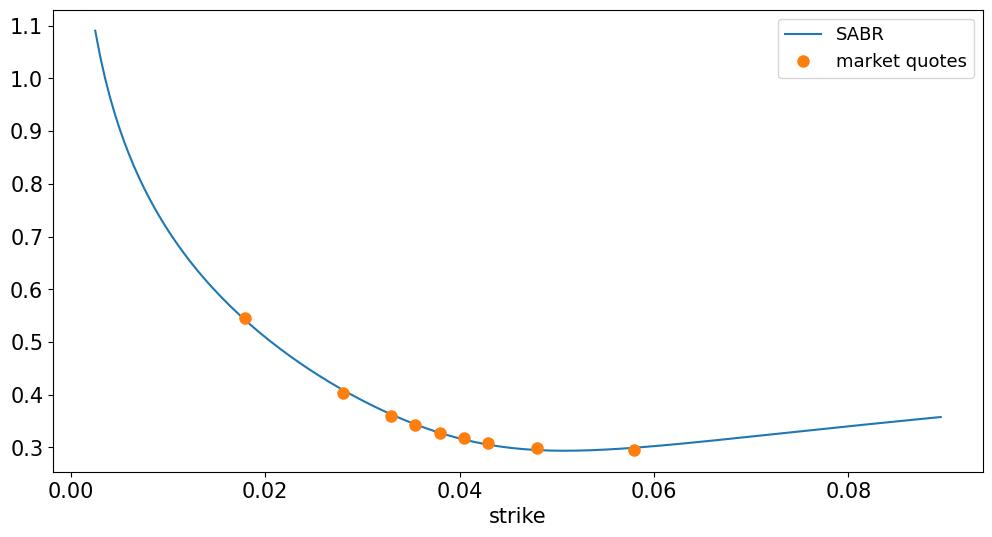

In [160]:
strikegrid = np.arange(.0025, .09, .0005)
if doSLIM:
    ivolgrid = sabr_slim(BETA,nustar,rhostar,F,strikegrid,Topt,volATM)    
else:
    ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,Topt)

sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['SABR'])

volquotes = vols.copy()
volquotes.loc['strike'] = strikes
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol':'market quotes'})

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='',marker='o',markersize=8,ax=ax)
plt.legend()

## 1.3
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)



In [161]:
NEWSTRIKE = .05
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)
discount = curves['discounts'].iloc[period_fwd+step : period_swap : step].sum()/freqswap
if doSLIM:
    newvol = sabr_slim(BETA,nustar,rhostar,F,NEWSTRIKE,Topt,volATM)
else:
    newvol = sabr(BETA,nustar,rhostar,alphastar,F,NEWSTRIKE,Topt)

newprice = N * blacks_formula(Topt,newvol,NEWSTRIKE,fwdswap,discount,isCall=isPayer)
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 5.00% is $0.2143.'

## 1.4

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.
$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.

In [162]:
doSLIM = True

,SABR Parameters
beta,0.7500
alpha,0.1422
nu,0.8156
rho,-0.4314
fit error,0.0001


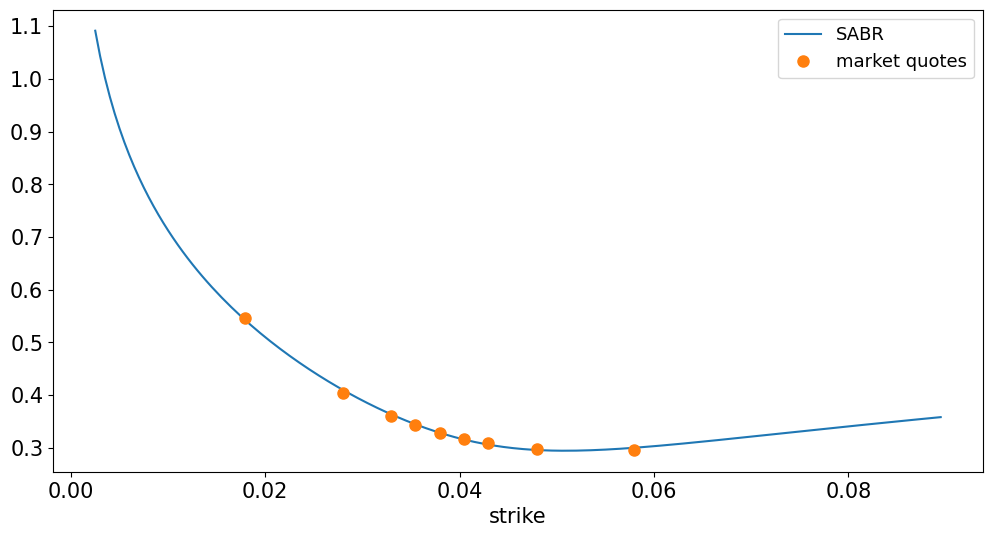

In [163]:
if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,Topt,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strikes,Topt,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strikes,Topt)

error = optim.fun

param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta', 'alpha', 'nu', 'rho', 'fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
display(param)

#Graph SABR curve
if doSLIM:
    ivolgrid = sabr_slim(BETA,nustar,rhostar,F,strikegrid,Topt,volATM)    
else:
    ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,Topt)

sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['SABR'])

volquotes = vols.copy()
volquotes.loc['strike'] = strikes
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol':'market quotes'})

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='',marker='o',markersize=8,ax=ax)
plt.legend()
plt.show()

***

# 2. SABR and Risk Management

Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens on `Feb 21, 2024`.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.

## 2.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate increased `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)

## 2.2

Now, we consider how the volatility may change with the underlying shift of `50bps`.

Using the same SABR parameters from `1.1`, and the strike grid from `1.2`, plot the new SABR curve accounting for the underlying rate shifting up `50bps`.

## 2.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `2.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`

## 2.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `2.1`?

In [175]:
INCREASE = 50
SHIFT = INCREASE/100/100
doSLIM = False

sabrcurve.rename(columns={'SABR':f'SABR: underlying at {DATE}'},inplace=True)

if doSLIM:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr_slim(BETA,nustar,rhostar,F+SHIFT,strikegrid,Topt,volATM)
else:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr(BETA,nustar,rhostar,alphastar,F+SHIFT,strikegrid,Topt)

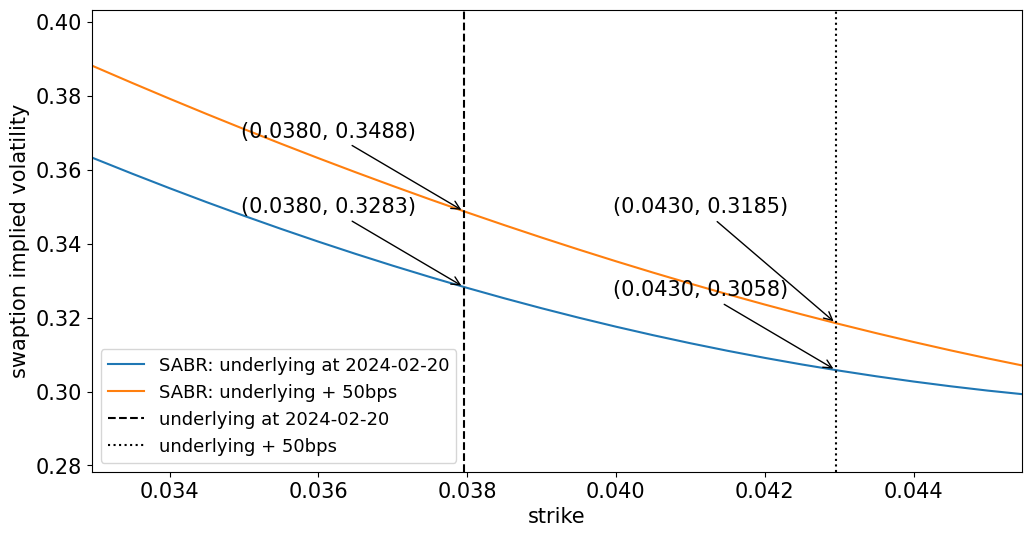

In [207]:
fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
plt.xlim([F-.005,F+.0075])
plt.ylim([volATM-.05,volATM+.075])
plt.axvline(F,color='k',linestyle='--',label=f'underlying at {DATE}')
plt.axvline(F+SHIFT,color='k',linestyle=':',label=f'underlying + {SHIFT*100*100:.0f}bps')
plt.ylabel('swaption implied volatility');
plt.xlabel('strike')
plt.legend();
# Add labels at the intersection points
plt.annotate(f'({F:.4f}, {volATM:.4f})', xy=(F, volATM), xytext=(F-0.003, volATM+0.02),
             arrowprops=dict(facecolor='blue', arrowstyle='->'))

y_intersect1 = np.interp(F, sabrcurve.index, sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'])

plt.annotate(f'({F:.4f}, {y_intersect1:.4f})', xy=(F, y_intersect1), xytext=(F - 0.003, y_intersect1+0.02),
             arrowprops=dict(facecolor='blue', arrowstyle='->'))

y_intersect2 = np.interp(F + SHIFT, sabrcurve.index, sabrcurve[f'SABR: underlying at {DATE}'])

plt.annotate(f'({F + SHIFT:.4f}, {y_intersect2:.4f})', xy=(F + SHIFT, y_intersect2), xytext=(F + SHIFT-0.003, y_intersect2+0.02),
             arrowprops=dict(facecolor='blue', arrowstyle='->'))

y_intersect3 = np.interp(F + SHIFT, sabrcurve.index, sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'])

plt.annotate(f'({F+SHIFT:.4f}, {y_intersect3:.4f})', xy=(F+SHIFT, y_intersect3), xytext=(F+SHIFT-0.003, volATM+0.02),
             arrowprops=dict(facecolor='orange', arrowstyle='->'))

plt.show()

In [216]:
y_intersects = pd.DataFrame([[volATM, y_intersect1],[y_intersect2,y_intersect3]], 
                            index = [f'strike: {F:.4f}', f'strike: {F + SHIFT:.4f}'], 
                            columns = [f'underlying at {DATE}',f'underlying + {SHIFT*100*100:.0f}bps'])
y_intersects

,underlying at 2024-02-20,underlying + 50bps
strike: 0.0380,0.328300,0.348781
strike: 0.0430,0.305804,0.318500


In [170]:
idloc = (sabrcurve.index.to_series()-fwdswap).abs().idxmin()

newvols = sabrcurve.loc[idloc]
strikeATM = strikes[idstrikeATM]

Frange = F + [0,SHIFT]

In [178]:
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)

discount = curves['discounts'].iloc[period_fwd+step : period_swap : step].sum()/freqswap

blackprices = pd.Series(N * blacks_formula(Topt-np.array([0,1/365]), newvols[0],strikeATM,Frange,discount,isCall=isPayer), index=[DATE,'shift'], name='static').to_frame().T
blackprices.loc['dynamic'] = N * blacks_formula(Topt-np.array([0,1/365]), newvols,strikeATM,Frange,discount,isCall=isPayer)
print('Prices + shifts:')
display(blackprices.style.format('{:.2f}'))

Prices + shifts:


,2024-02-20,shift
static,0.89,1.46
dynamic,0.89,1.52


In [180]:
delta = (blackprices.diff(axis=1) / SHIFT)['shift'].rename('delta')
print("Static vs Dynamic Delta: ")
display(delta.to_frame().style.format('{:.2f}'))
delta_relative_change = delta.pct_change().loc['dynamic']
display(f'Relative change to delta: {delta_relative_change:.2%}.')

Static vs Dynamic Delta: 


,delta
static,114.70
dynamic,125.60


'Relative change to delta: 9.51%.'

***